# Phyloseq object for geothermal BGCs and figure generation for manuscript

# Load my libraries

In [89]:
library(phyloseq)
library(tidyr)
library(ggplot2)
library(microbiome)
library(dplyr)
library(tibble)
library(vegan)
library(ggtern)
library(ggforce)
library(checkmate)
library(readr)
library(cluster)
library(tidyverse)
library(factoextra)
library(ggnewscale)
library(ggsignif)
library(grid)
library(svglite)
library(RColorBrewer)
library(viridis)
library(patchwork)
library(jsonlite)
library(FSA) 
library(marmap)
library(scico)
library(readxl)

# Glab theme

In [90]:
theme_glab = function(
  base_size=12,
  base_family="",
  base_line_size=base_size / 180,
  base_rect_size=base_size / 180
) {

  font = "Helvetica"

  ggplot2::theme_bw(
    base_size=base_size,
    base_family=base_family,
    base_line_size=base_line_size
  ) %+replace%
  ggplot2::theme(
    legend.background=ggplot2::element_blank(),
    legend.title=ggplot2::element_text(
      color=grDevices::rgb(100, 100, 100, maxColorValue=255),
      size=ggplot2::rel(1.65),
      hjust=0
    ),
    legend.text=ggplot2::element_text(
      color=grDevices::rgb(100, 100, 100, maxColorValue=255),
      size=ggplot2::rel(1.65)
    ),
    legend.key.size=ggplot2::unit(0.8, "lines"),
    plot.title=ggplot2::element_text(
      color=grDevices::rgb(100, 100, 100, maxColorValue=255),
      hjust=0
    ),
    axis.title=ggplot2::element_text(
      color=grDevices::rgb(100, 100, 100, maxColorValue=255),
      size=ggplot2::rel(1.65)
    ),
    axis.text=ggplot2::element_text(
      color=grDevices::rgb(100, 100, 100, maxColorValue=255),
      size=ggplot2::rel(1.65)
    ),
    plot.caption=ggplot2::element_text(
      color=grDevices::rgb(100, 100, 100, maxColorValue=255),
      size=ggplot2::rel(1.35),
      hjust=1
    ),
    panel.grid.major=ggplot2::element_blank(),
    panel.grid.minor=ggplot2::element_blank(),
    panel.border=ggplot2::element_rect(
      colour=grDevices::rgb(100, 100, 100, maxColorValue=255),
      fill=NA
    ),
    complete=TRUE
  )
}

# Phyloseq Object Creation

In [91]:
otu <- read.csv("otu_REAL.csv", check.names = FALSE)
taxa <- read.csv("BGCs_tax_table.csv", check.names = FALSE)
env_data <- read.csv("env_data_BGC.csv", check.names = FALSE)

# Set 'Product' as row names while keeping it in the data 
rownames(otu) <- otu$Product
otu <- otu[,-1]  # Remove 'Product' column

# Ensure all values in OTU table are numeric
otu[] <- lapply(otu, as.numeric)

# Set 'Product' as row names in taxonomy table
rownames(taxa) <- taxa$Product
taxa <- taxa[,-1]  # Remove 'Product' column

# Ensure sample names match between metadata and OTU table
rownames(env_data) <- env_data$BIOSAMPLE_ID

# Remove extra spaces or hidden characters in sample names
env_data$BIOSAMPLE_ID <- trimws(env_data$BIOSAMPLE_ID)
colnames(otu) <- trimws(colnames(otu))

# Replace empty strings with NA in the new variable
env_data[env_data == ""] <- NA
# Calculate the percentage of NA values per column
na_percentage <- colSums(is.na(env_data)) / nrow(env_data) * 100
# Identify columns where more than 70% of values are NA
columns_to_drop <- names(na_percentage[na_percentage > 40])

# Remove those columns from the dataset
env_data <- env_data[, !(colnames(env_data) %in% columns_to_drop)]

# Replace NA with median (only for numeric columns and those that remain)
env_data[] <- lapply(env_data, function(x)
  if (is.numeric(x)) ifelse(is.na(x), median(x, na.rm = TRUE), x) else x
)

# Convert to phyloseq OTU table
otu_physeq <- otu_table(as.matrix(otu), taxa_are_rows = TRUE)

# Convert to phyloseq taxonomy table
taxa_physeq <- tax_table(as.matrix(taxa))

# Convert to phyloseq sample data
env_data_physeq <- sample_data(env_data)

physeq <- phyloseq(otu_physeq, taxa_physeq, env_data_physeq)

print(physeq)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 67 taxa and 200 samples ]
sample_data() Sample Data:       [ 200 samples by 31 sample variables ]
tax_table()   Taxonomy Table:    [ 67 taxa by 3 taxonomic ranks ]


# Normalisation and prep for graphs

In [92]:
bgc_n_data <- transform_sample_counts(physeq, function(x) ((x / sum(x))*median(readcount(physeq))))
ps_ra = transform_sample_counts(physeq, function(x){x / sum(x)})

# NMDS

Run 0 stress 0.1890155 
Run 1 stress 0.1920875 
Run 2 stress 0.1935037 
Run 3 stress 0.1894897 
... Procrustes: rmse 0.03040609  max resid 0.3606734 
Run 4 stress 0.1895169 
Run 5 stress 0.1943596 
Run 6 stress 0.190611 
Run 7 stress 0.1973647 
Run 8 stress 0.188428 
... New best solution
... Procrustes: rmse 0.01031417  max resid 0.1210574 
Run 9 stress 0.1921769 
Run 10 stress 0.195247 
Run 11 stress 0.1932194 
Run 12 stress 0.1932066 
Run 13 stress 0.1899009 
Run 14 stress 0.191361 
Run 15 stress 0.1897705 
Run 16 stress 0.1920384 
Run 17 stress 0.1887945 
... Procrustes: rmse 0.01771754  max resid 0.2213053 
Run 18 stress 0.1884189 
... New best solution
... Procrustes: rmse 0.004473456  max resid 0.03523169 
Run 19 stress 0.192005 
Run 20 stress 0.1941545 
*** Best solution was not repeated -- monoMDS stopping criteria:
    12: no. of iterations >= maxit
     8: stress ratio > sratmax


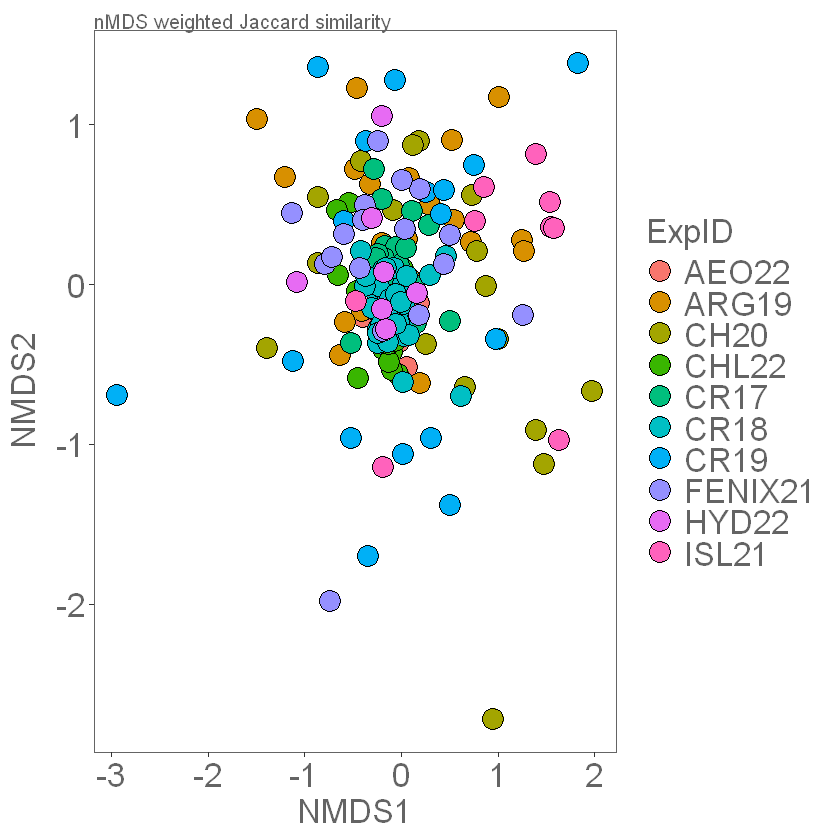

In [93]:
#Weighted NMDS
prok_dist_wjac <- phyloseq::distance(bgc_n_data, method = "jaccard")
prok_nmds_jw <- ordinate(bgc_n_data, prok_dist_wjac, method = "NMDS",trymax=100)

plot_ordination(ps_ra, prok_nmds_jw, type = "samples", title = "nMDS weighted Jaccard similarity") +

geom_point(aes(fill = ExpID), size = 6, color = "black", stroke = 0.3, shape=21) +

theme_glab() +
  theme(legend.position = "right")


Run 0 stress 0.176382 
Run 1 stress 0.1749842 
... New best solution
... Procrustes: rmse 0.04762367  max resid 0.281149 
Run 2 stress 0.180462 
Run 3 stress 0.1774597 
Run 4 stress 0.1719733 
... New best solution
... Procrustes: rmse 0.04274621  max resid 0.3003101 
Run 5 stress 0.1768407 
Run 6 stress 0.1741324 
Run 7 stress 0.1739962 
Run 8 stress 0.1737783 
Run 9 stress 0.1757345 
Run 10 stress 0.1750459 
Run 11 stress 0.1765491 
Run 12 stress 0.1798865 
Run 13 stress 0.178512 
Run 14 stress 0.1769403 
Run 15 stress 0.1726979 
Run 16 stress 0.1802772 
Run 17 stress 0.1784768 
Run 18 stress 0.1809894 
Run 19 stress 0.1763825 
Run 20 stress 0.1825912 
*** Best solution was not repeated -- monoMDS stopping criteria:
     3: no. of iterations >= maxit
    17: stress ratio > sratmax


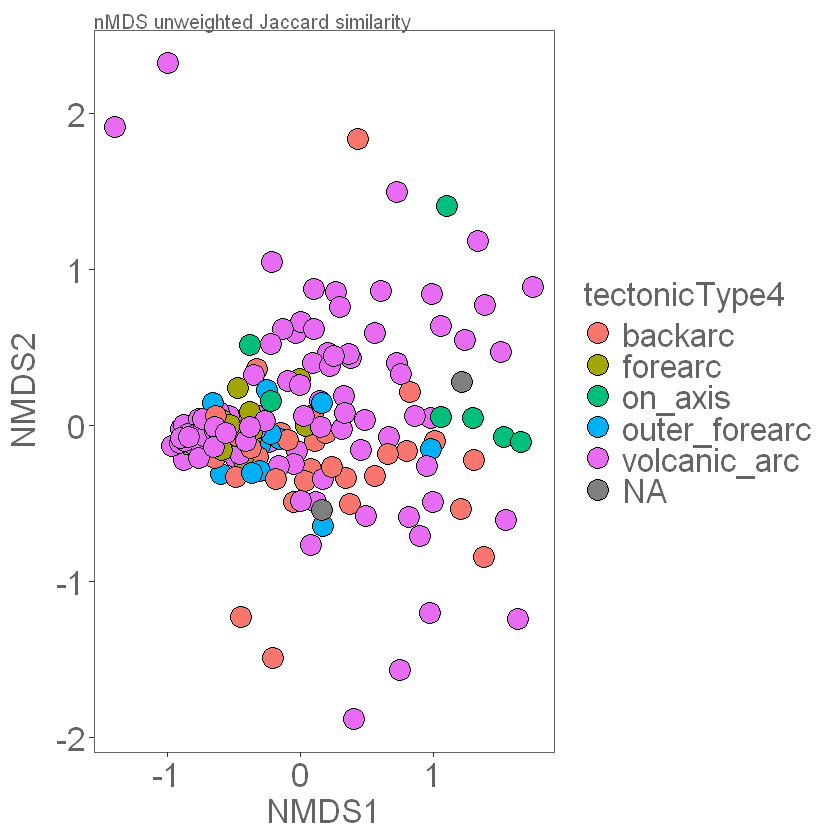

In [94]:
#Unweighted NMDS by Tectonic
prok_dist_unjac <- phyloseq::distance(bgc_n_data, method = "jaccard", binary = TRUE)
prok_nmds_juw <- ordinate(bgc_n_data, prok_dist_unjac, method = "NMDS",trymax=100)
plot_ordination(ps_ra, prok_nmds_juw, type = "samples", title = "nMDS unweighted Jaccard similarity") +

geom_point(aes(fill = tectonicType4), size = 6, color = "black", stroke = 0.3, shape=21) +

theme_glab() +
    theme(legend.position = "right")


Run 0 stress 0.176382 
Run 1 stress 0.1793584 
Run 2 stress 0.1794774 
Run 3 stress 0.1737927 
... New best solution
... Procrustes: rmse 0.03372502  max resid 0.338562 
Run 4 stress 0.1818501 
Run 5 stress 0.1724992 
... New best solution
... Procrustes: rmse 0.04780928  max resid 0.2961131 
Run 6 stress 0.1737879 
Run 7 stress 0.1744148 
Run 8 stress 0.175759 
Run 9 stress 0.1747955 
Run 10 stress 0.1809559 
Run 11 stress 0.1760031 
Run 12 stress 0.1734252 
Run 13 stress 0.1809311 
Run 14 stress 0.1828668 
Run 15 stress 0.1821097 
Run 16 stress 0.1828756 
Run 17 stress 0.1731703 
Run 18 stress 0.1840625 
Run 19 stress 0.1831187 
Run 20 stress 0.1819352 
*** Best solution was not repeated -- monoMDS stopping criteria:
     3: no. of iterations >= maxit
    17: stress ratio > sratmax


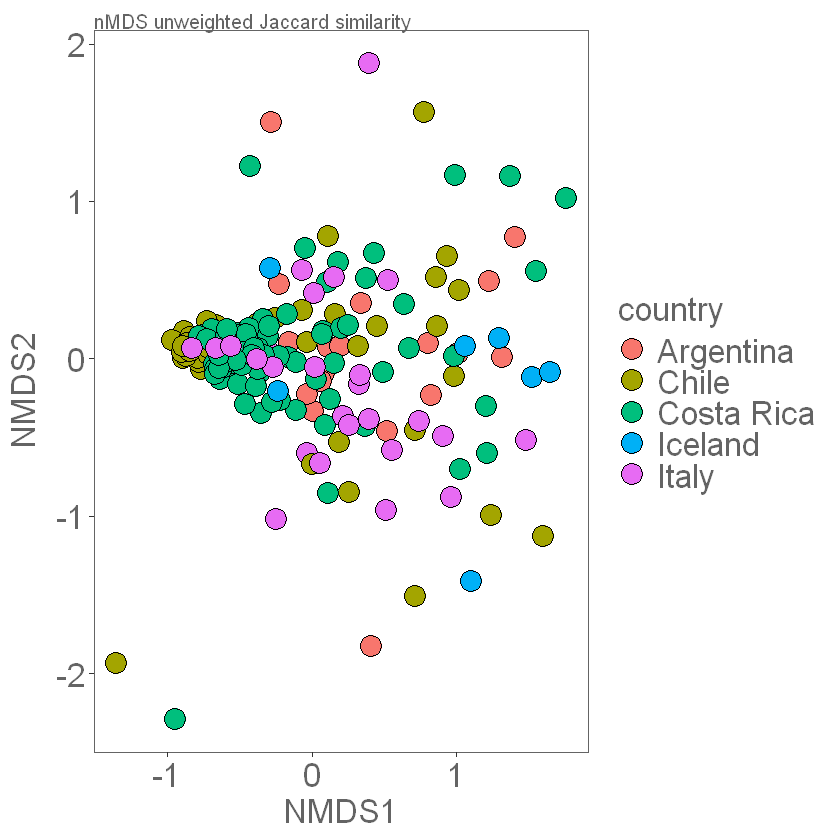

In [95]:
#Unweighted NMDS by Country
prok_dist_unjac <- phyloseq::distance(bgc_n_data, method = "jaccard", binary = TRUE)
prok_nmds_juw <- ordinate(bgc_n_data, prok_dist_unjac, method = "NMDS",trymax=100)
plot_ordination(ps_ra, prok_nmds_juw, type = "samples", title = "nMDS unweighted Jaccard similarity") +

geom_point(aes(fill = country), size = 6, color = "black", stroke = 0.3, shape=21) +

theme_glab() +
    theme(legend.position = "right")

# PCOAs

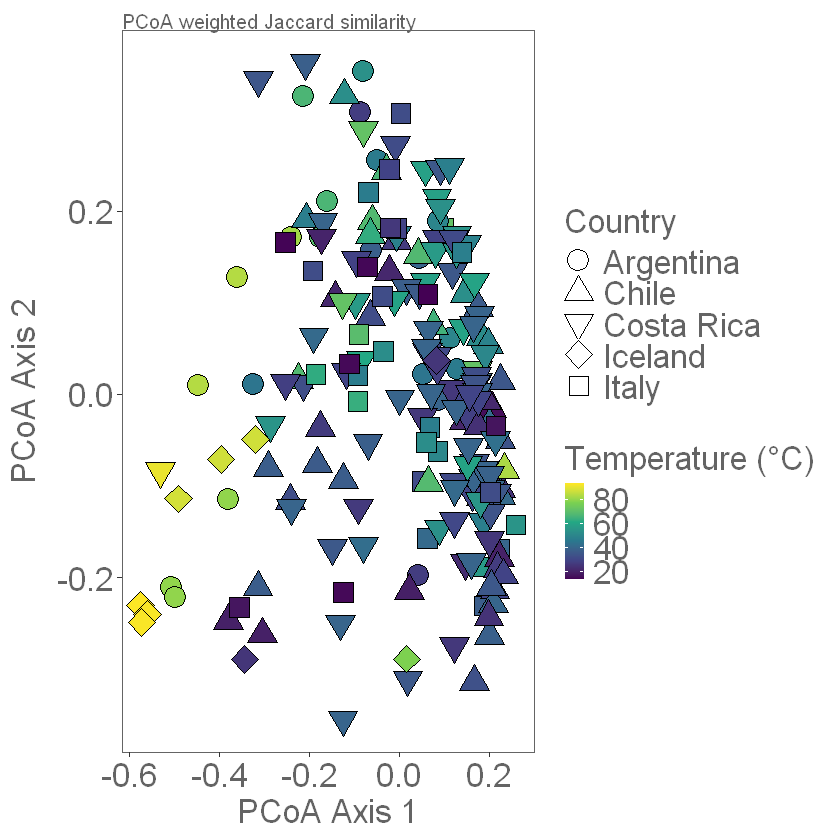

In [96]:
#Ordinate with weighted Jaccard
prok_pcoa_jw <- ordinate(bgc_n_data, prok_dist_wjac, method = "PCoA", trymax = 100)

#Get coordinates
coords <- as.data.frame(prok_pcoa_jw$vectors)
coords$SampleID <- rownames(coords)

#Get metadata
meta <- as.data.frame(sample_data(bgc_n_data))
meta$SampleID <- rownames(meta)

#Merge coordinates with selected metadata
coords <- left_join(coords, meta[, c("SampleID", "temp", "country")], by = "SampleID")

country_shapes <- c(
  "Argentina" = 21,
  "Chile" = 24,
  "Italy" = 22,
  "Iceland" = 23,
  "Costa Rica" = 25
)

pcoa_temp_plot <- ggplot(coords, aes(x = Axis.1, y = Axis.2)) +
  geom_point(aes(fill = temp, shape = country),
             size = 6, color = "black", stroke = 0.3) +
  scale_shape_manual(name = "Country", values = country_shapes) +
  scale_fill_viridis_c(name = "Temperature (°C)") +
  labs(title = "PCoA weighted Jaccard similarity",
       x = "PCoA Axis 1", y = "PCoA Axis 2") +
  theme_glab() +
  theme(legend.position = "right")

ggsave(
  filename = "../figures/pcoa_weighted_temp.svg",
  plot = pcoa_temp_plot,
  device = "svg",
  width = 12,
  height = 6
)
print(pcoa_temp_plot)


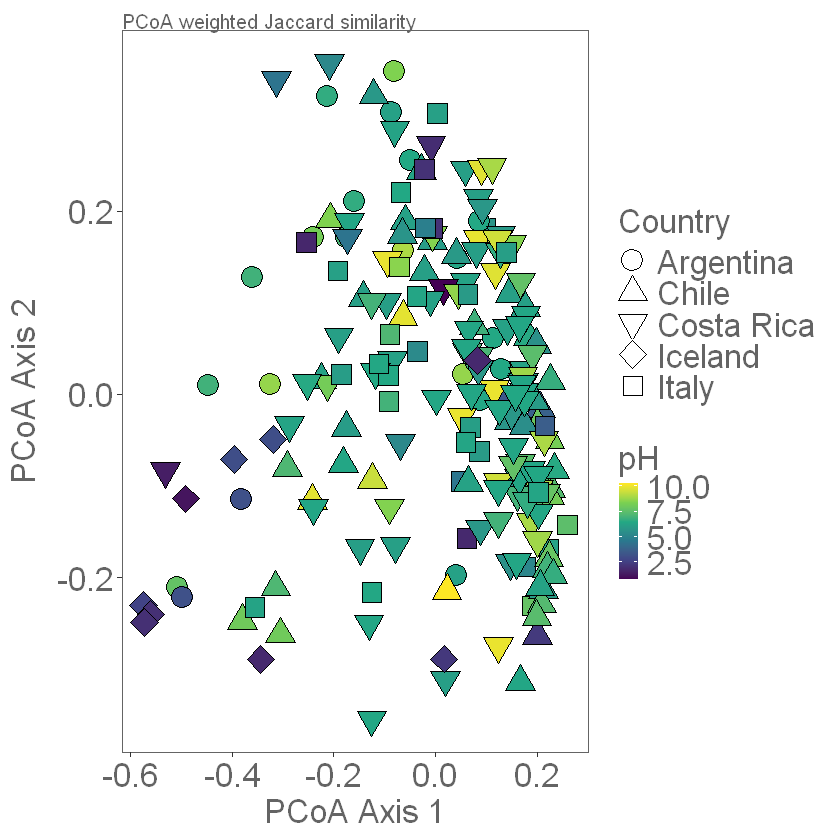

In [97]:
# Ordinate with weighted Jaccard
prok_pcoa_jw <- ordinate(bgc_n_data, prok_dist_wjac, method = "PCoA", trymax = 100)

# Get coordinates
coords <- as.data.frame(prok_pcoa_jw$vectors)
coords$SampleID <- rownames(coords)

# Get metadata
meta <- as.data.frame(sample_data(bgc_n_data))
meta$SampleID <- rownames(meta)

# Merge coordinates w metadata
coords <- left_join(coords, meta[, c("SampleID", "ph", "country")], by = "SampleID")

country_shapes <- c(
  "Argentina" = 21,
  "Chile" = 24,
  "Italy" = 22,
  "Iceland" = 23,
  "Costa Rica" = 25
)

pcoa_ph_plot <- ggplot(coords, aes(x = Axis.1, y = Axis.2)) +
  geom_point(aes(fill = ph, shape = country),
             size = 6, color = "black", stroke = 0.3) +
  scale_shape_manual(name = "Country", values = country_shapes) +
  scale_fill_viridis_c(name = "pH") +
  labs(title = "PCoA weighted Jaccard similarity",
       x = "PCoA Axis 1", y = "PCoA Axis 2") +
  theme_glab() +
  theme(legend.position = "right")

print(pcoa_ph_plot)

ggsave(
  filename = "../figures/pcoa_weighted_ph.svg",
  plot = pcoa_ph_plot,
  device = "svg",
  width = 12,
  height = 6
)


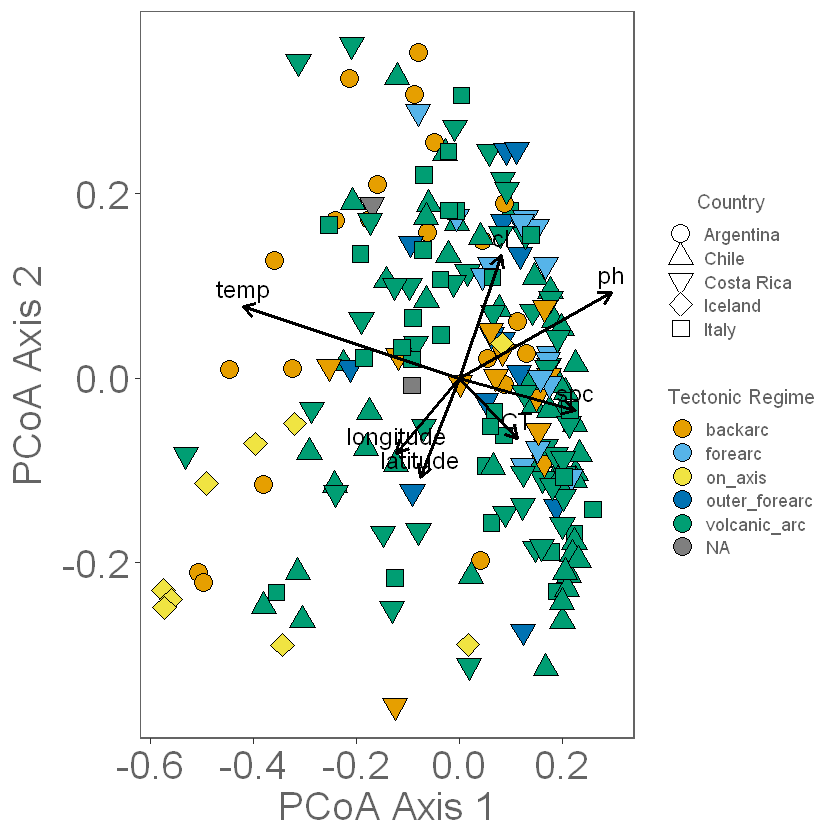

In [98]:
# Ordinate with weighted Jaccard
prok_pcoa_jw <- ordinate(bgc_n_data, prok_dist_wjac, method = "PCoA")

# Get coordinates
coords_w <- as.data.frame(prok_pcoa_jw$vectors)
coords_w$SampleID <- rownames(coords_w)

# Add metadata
meta <- as.data.frame(sample_data(bgc_n_data))
meta$SampleID <- rownames(meta)

# Merge metadata
coords_w <- left_join(coords_w, meta[, c("SampleID", "country", "tectonicType4",
                                         "temp", "ph", "CT", "cl", "so4", "spc", 
                                         "elevation", "latitude", "longitude", "na")],
                      by = "SampleID")

# Run envfit on weighted ordination
envfit_res_w <- envfit(prok_pcoa_jw$vectors, coords_w[, c("temp", "ph", "CT", "cl", "spc",
                                                           "latitude", "longitude")], permutations = 999)
arrows_df_w <- as.data.frame(scores(envfit_res_w, display = "vectors"))
arrows_df_w$Variable <- rownames(arrows_df_w)

tectonic_colors <- c(
  "backarc" = "#E69F00",
  "forearc" = "#56B4E9",
  "volcanic_arc" = "#009E73",
  "on_axis" = "#F0E442",
  "outer_forearc" = "#0072B2",
  "NA" = "#999999"
)

country_shapes <- c(
  "Argentina" = 21,
  "Chile" = 24,
  "Italy" = 22,
  "Iceland" = 23,
  "Costa Rica" = 25
)


pcoa_weighted_plot <- ggplot(coords_w, aes(x = Axis.1, y = Axis.2)) +
  geom_point(aes(shape = country, fill = tectonicType4),
             size = 5, color = "black", stroke = 0.4) +
  scale_shape_manual(name = "Country", values = country_shapes) +
  scale_fill_manual(name = "Tectonic Regime", values = tectonic_colors) +

  geom_segment(data = arrows_df_w,
               aes(x = 0, y = 0, xend = Axis.1, yend = Axis.2),
               arrow = arrow(length = unit(0.3, "cm")),
               color = "black", size = 1) +
  geom_text(data = arrows_df_w,
            aes(x = Axis.1, y = Axis.2, label = Variable),
            color = "black", vjust = -0.5, size = 5) +

  labs(
    x = "PCoA Axis 1",
    y = "PCoA Axis 2"
  ) +

  guides(
    shape = guide_legend(order = 1, title.position = "top"),
    fill = guide_legend(order = 2, title.position = "top",
                        override.aes = list(shape = 21, color = "black", size = 5))
  ) +

  theme_glab(base_size = 14) +
  theme(
    legend.position = "right",
    legend.box = "vertical",
    legend.box.just = "left",
    legend.title.align = 0.5,
    legend.text = element_text(size = 11),
    legend.title = element_text(size = 12)
  )

print(pcoa_weighted_plot)

ggsave(
  filename = "../figures/pcoa_weighted_envfit_NO_K_MEAN.svg",
  plot = pcoa_weighted_plot,
  device = "svg",
  width = 12,
  height = 6
)



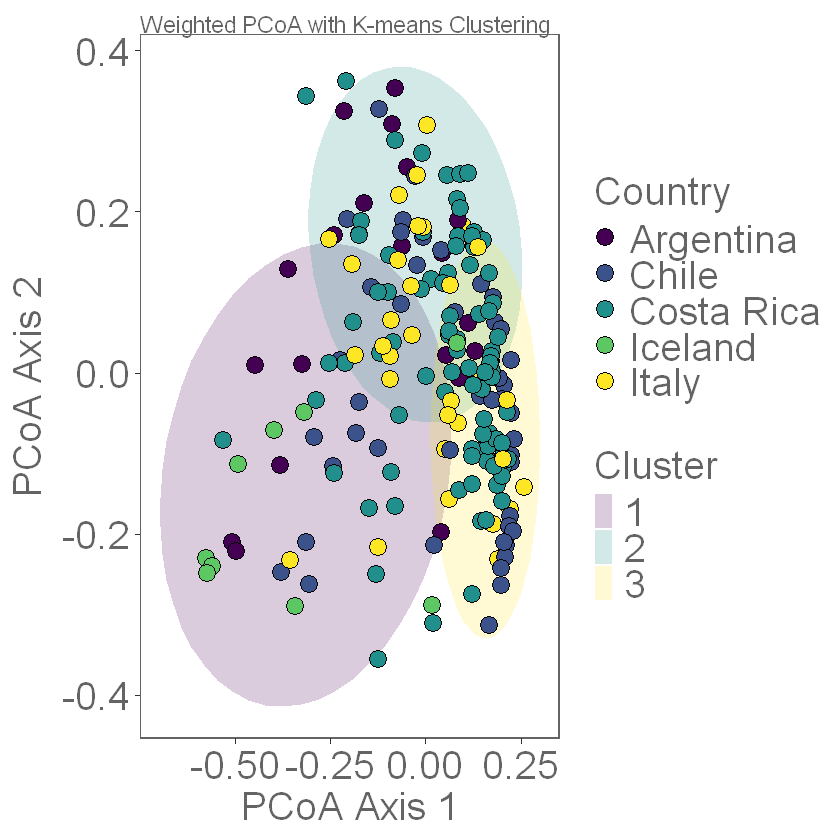

In [99]:
#PCOA with K-means clustering
# Run PCoA (weighted Jaccard)
prok_pcoa_jw <- ordinate(bgc_n_data, prok_dist_wjac, method = "PCoA", trymax = 100)

# Extract coordinates
coords <- as.data.frame(prok_pcoa_jw$vectors)
coords$SampleID <- rownames(coords)

# K-means clustering on first two axes
set.seed(123)
k_res <- kmeans(coords[, c("Axis.1", "Axis.2")], centers = 3)
coords$Cluster <- as.factor(k_res$cluster)

# Extract  and merge metadata
meta <- as.data.frame(sample_data(bgc_n_data))
meta$SampleID <- rownames(meta)
coords <- left_join(coords, meta[, c("SampleID", "BIOSAMPLE_ID", "country")], by = "SampleID")

ggplot(coords, aes(x = Axis.1, y = Axis.2)) +
  stat_ellipse(aes(fill = Cluster, group = Cluster),
               type = "norm", geom = "polygon", alpha = 0.2, color = NA) +
  scale_fill_viridis_d(option = "D", name = "Cluster") +

  ggnewscale::new_scale_fill() +

  geom_point(aes(fill = country), shape = 21, size = 5, color = "black", stroke = 0.3) +
  scale_fill_viridis_d(option = "D", name = "Country") +

  labs(
    title = "Weighted PCoA with K-means Clustering",
    x = "PCoA Axis 1",
    y = "PCoA Axis 2"
  ) +
  theme_glab(base_size = 14) +
  theme(legend.position = "right")

#Export cluster assignments
BIOSAMPLE_ID_clusters <- coords %>%
  group_by(BIOSAMPLE_ID, Cluster) %>%
  tally() %>%
  slice_max(order_by = n, n = 1, with_ties = FALSE) %>%
  ungroup() %>%
  select(BIOSAMPLE_ID, Cluster)


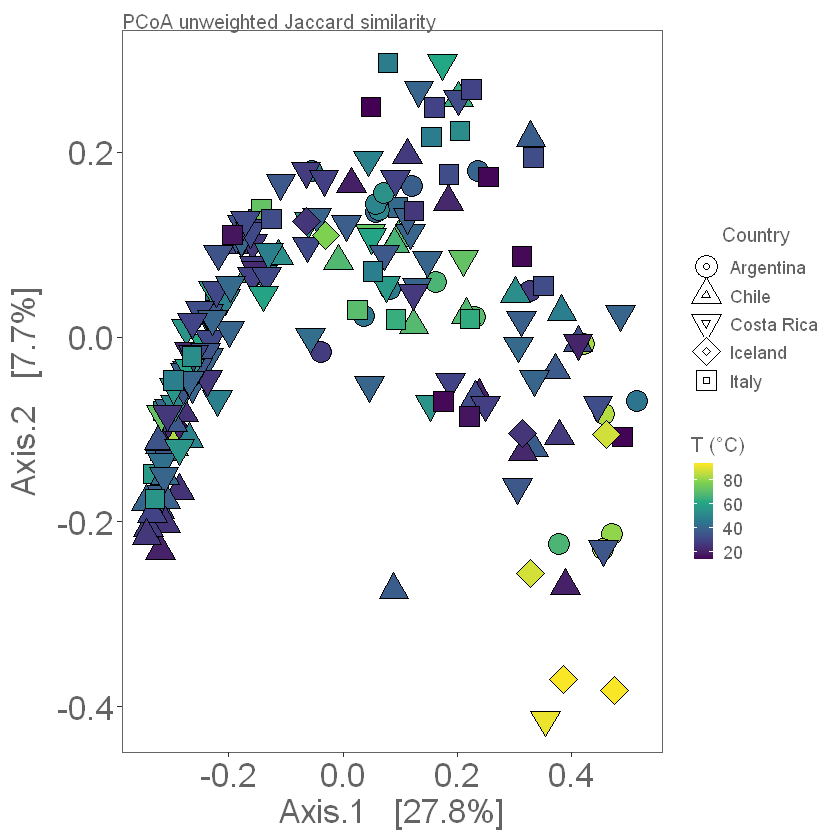

In [100]:
country_shapes <- c(
  "Argentina" = 21,
  "Chile" = 24,
  "Italy" = 22,
  "Iceland" = 23,
  "Costa Rica" = 25
)

# Run PCoA (unweighted Jaccard) coloured by temperature
prok_pcoa_juw <- ordinate(bgc_n_data, prok_dist_unjac, method = "PCoA")


plot_ordination(ps_ra, prok_pcoa_juw, type = "samples",
                title = "PCoA unweighted Jaccard similarity", axes = c(1,2)) +
  geom_point(aes(fill = temp, shape = country),
             size = 6, color = "black", stroke = 0.3) +
  scale_shape_manual(name = "Country", values = country_shapes) +
  scale_fill_viridis_c(name = "T (°C)") +
  guides(
    shape = guide_legend(
      override.aes = list(fill = NA, stroke = 0.5, color = "black")
    )
  ) +
  theme_glab() +
  theme(
    legend.position = "right",
    legend.title.align = 0.5,
    legend.text = element_text(size = 11),
    legend.title = element_text(size = 12)
  )


ggsave(
  filename = "../figures/pcoa_unweighted_temp.svg",
  device = "svg",
  width = 12,
  height = 6
)


pdf 
  2

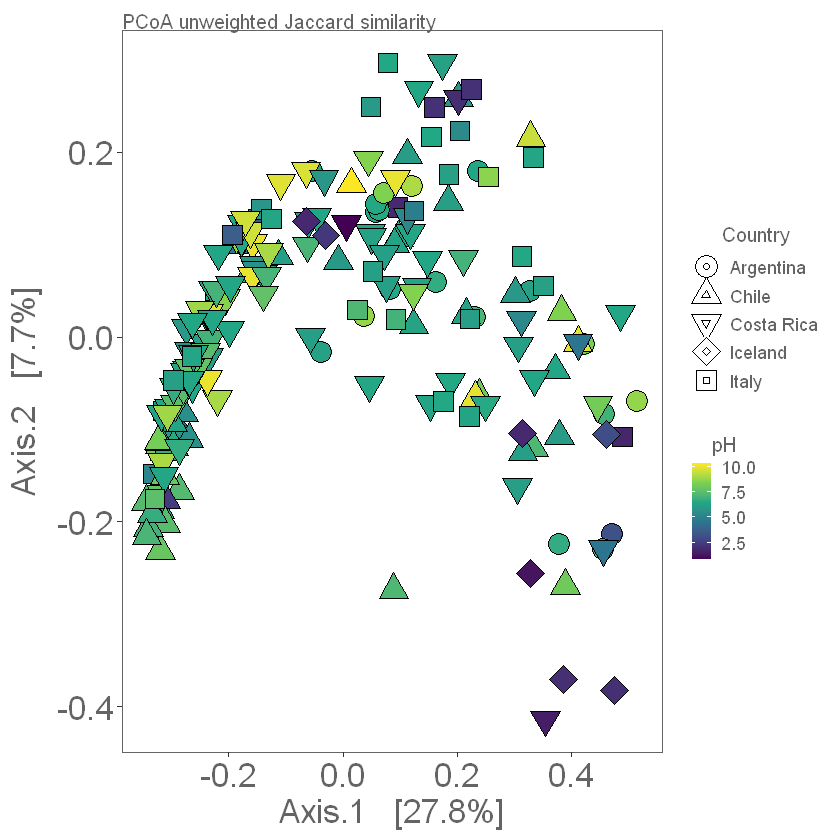

In [101]:
country_shapes <- c(
  "Argentina" = 21,
  "Chile" = 24,
  "Italy" = 22,
  "Iceland" = 23,
  "Costa Rica" = 25
)

# Run PCoA (unweighted Jaccard) coloured by ph
prok_pcoa_juw <- ordinate(bgc_n_data, prok_dist_unjac, method = "PCoA")


plot_ordination(ps_ra, prok_pcoa_juw, type = "samples",
                title = "PCoA unweighted Jaccard similarity", axes = c(1,2)) +
  geom_point(aes(fill = ph, shape = country),
             size = 6, color = "black", stroke = 0.3) +
  scale_shape_manual(name = "Country", values = country_shapes) +
  scale_fill_viridis_c(name = "pH") +
  guides(
    shape = guide_legend(
      override.aes = list(fill = NA, stroke = 0.5, color = "black")
    )
  ) +
  theme_glab() +
  theme(
    legend.position = "right",
    legend.title.align = 0.5,
    legend.text = element_text(size = 11),
    legend.title = element_text(size = 12)
  )


svglite("../figures/pcoa_unweighted_ph.svg", width = 12, height = 6)

plot_ordination(ps_ra, prok_pcoa_juw, type = "samples",
                title = "PCoA unweighted Jaccard similarity", axes = c(1,2)) +
  geom_point(aes(fill = ph, shape = country),
             size = 6, color = "black", stroke = 0.3) +
  scale_shape_manual(name = "Country", values = country_shapes) +
  scale_fill_viridis_c(name = "pH") +
  guides(
    shape = guide_legend(
      override.aes = list(fill = NA, stroke = 0.5, color = "black")
    )
  ) +
  theme_glab() +
  theme(
    legend.position = "right",
    legend.title.align = 0.5,
    legend.text = element_text(size = 11),
    legend.title = element_text(size = 12)
  )

dev.off()

pdf 
  2

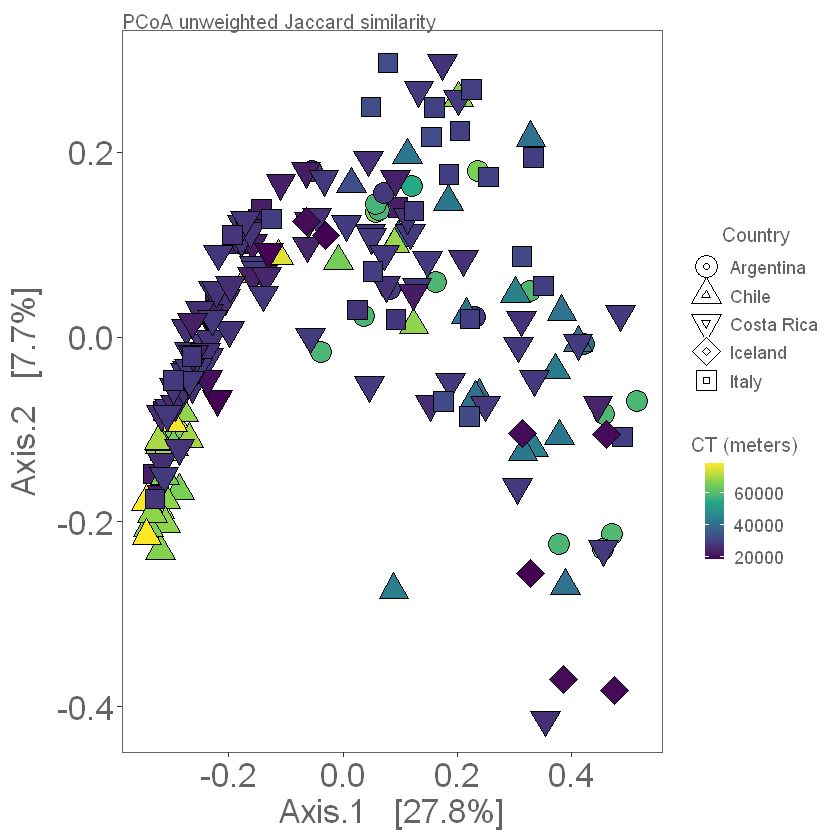

In [102]:
country_shapes <- c(
  "Argentina" = 21,
  "Chile" = 24,
  "Italy" = 22,
  "Iceland" = 23,
  "Costa Rica" = 25
)

# Run PCoA (unweighted Jaccard) coloured by CT -Crustal Thickness
prok_pcoa_juw <- ordinate(bgc_n_data, prok_dist_unjac, method = "PCoA")


plot_ordination(ps_ra, prok_pcoa_juw, type = "samples",
                title = "PCoA unweighted Jaccard similarity", axes = c(1,2)) +
  geom_point(aes(fill = CT, shape = country),
             size = 6, color = "black", stroke = 0.3) +
  scale_shape_manual(name = "Country", values = country_shapes) +
  scale_fill_viridis_c(name = "CT (meters)") +
  guides(
    shape = guide_legend(
      override.aes = list(fill = NA, stroke = 0.5, color = "black")
    )
  ) +
  theme_glab() +
  theme(
    legend.position = "right",
    legend.title.align = 0.5,
    legend.text = element_text(size = 11),
    legend.title = element_text(size = 12)
  )



svglite("../figures/pcoa_CT.svg", width = 12, height = 6)

plot_ordination(ps_ra, prok_pcoa_juw, type = "samples",
                title = "PCoA unweighted Jaccard similarity", axes = c(1,2)) +
  geom_point(aes(fill = ph, shape = country),
             size = 6, color = "black", stroke = 0.3) +
  scale_shape_manual(name = "Country", values = country_shapes) +
  scale_fill_viridis_c(name = "CT (meters)") +
  guides(
    shape = guide_legend(
      override.aes = list(fill = NA, stroke = 0.5, color = "black")
    )
  ) +
  theme_glab() +
  theme(
    legend.position = "right",
    legend.title.align = 0.5,
    legend.text = element_text(size = 11),
    legend.title = element_text(size = 12)
  )
# Close the device
dev.off()

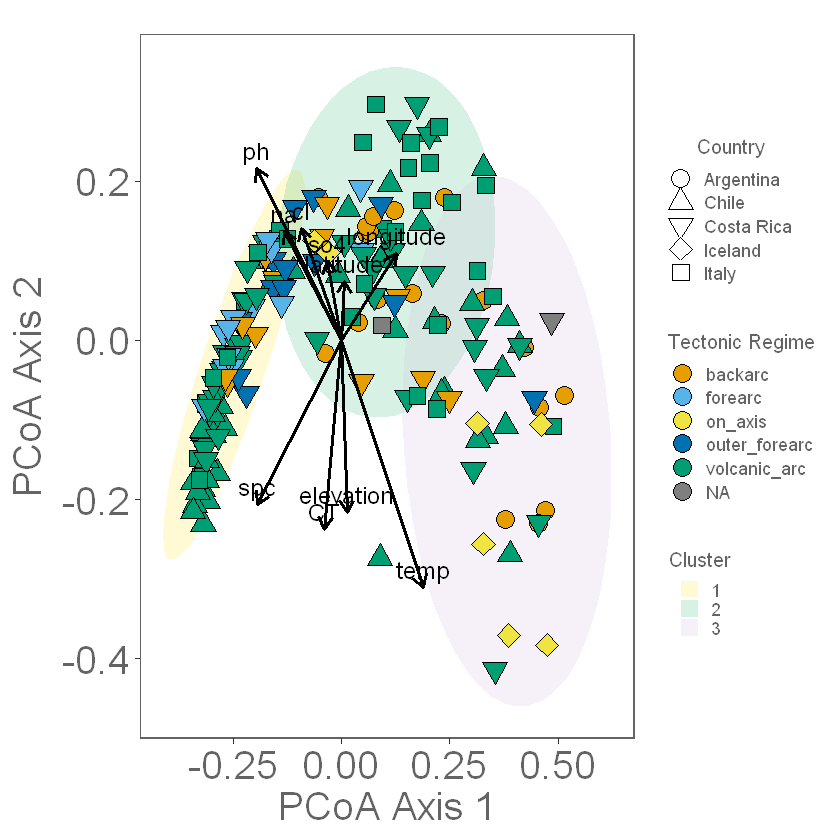

In [103]:
# Prepare to plot PCoa with envfit and K menas clustering
prok_pcoa_juw <- ordinate(bgc_n_data, prok_dist_unjac, method = "PCoA")


coords <- as.data.frame(prok_pcoa_juw$vectors)
coords$SampleID <- rownames(coords)


#K-means clustering
set.seed(123)
k_res <- kmeans(coords[, c("Axis.1", "Axis.2")], centers = 3)
coords$Cluster <- as.factor(k_res$cluster)
coords$Cluster <- as.character(coords$Cluster)
coords$Cluster[coords$Cluster == "1"] <- "temp"
coords$Cluster[coords$Cluster == "3"] <- "1"
coords$Cluster[coords$Cluster == "temp"] <- "3"
coords$Cluster <- as.factor(coords$Cluster)

#Metadata
meta <- as.data.frame(sample_data(bgc_n_data))
meta$SampleID <- rownames(meta)

#Merge metadata
coords <- left_join(coords, meta[, c("SampleID", "country", "tectonicType4",
                                     "temp", "ph", "CT", "cl", "so4", "spc", "elevation", "latitude", "longitude", "na")],
                    by = "SampleID")

#Run envfit
envfit_res <- envfit(prok_pcoa_juw$vectors, coords[, c("temp", "ph", "CT", "cl", "so4", "spc",
                                                       "elevation", "latitude", "longitude", "na")], permutations = 999)
arrows_df <- as.data.frame(scores(envfit_res, display = "vectors"))
arrows_df$Variable <- rownames(arrows_df)


tectonic_colors <- c(
  "backarc" = "#E69F00",
  "forearc" = "#56B4E9",
  "volcanic_arc" = "#009E73",
  "on_axis" = "#F0E442",
  "outer_forearc" = "#0072B2",
  "NA" = "#999999"
)

country_shapes <- c(
  "Argentina" = 21,
  "Chile" = 24,
  "Italy" = 22,
  "Iceland" = 23,
  "Costa Rica" = 25
)


ggplot(coords, aes(x = Axis.1, y = Axis.2)) +
  # Ellipses by cluster
stat_ellipse(aes(fill = Cluster, group = Cluster),
             type = "norm", geom = "polygon", alpha = 0.2, color = NA) +
scale_fill_manual(
  name = "Cluster",
  values = c("1" = "#FDE725", "2" = "#35B779", "3" = "#D4B9DA")
) +

  # New fill scale for tectonic regime
  ggnewscale::new_scale_fill() +

  # Points with tectonic fill and country shape
  geom_point(aes(shape = country, fill = tectonicType4),
             size = 5, color = "black", stroke = 0.4) +
  scale_shape_manual(name = "Country", values = country_shapes) +
  scale_fill_manual(name = "Tectonic Regime", values = tectonic_colors) +

  # Environmental arrows
  geom_segment(data = arrows_df,
               aes(x = 0, y = 0, xend = Axis.1, yend = Axis.2),
               arrow = arrow(length = unit(0.3, "cm")),
               color = "black", size = 1) +
  geom_text(data = arrows_df,
            aes(x = Axis.1, y = Axis.2, label = Variable),
            color = "black", vjust = -0.5, size = 5) +

  labs(
    title = "",
    x = "PCoA Axis 1",
    y = "PCoA Axis 2"
  ) +

  # Legend layout with correct color fix
  guides(
    shape = guide_legend(order = 1, title.position = "top"),
    fill = guide_legend(order = 2, title.position = "top",
                        override.aes = list(shape = 21, color = "black", size = 5))
  ) +

  theme_glab(base_size = 14) +
  theme(
    legend.position = "right",
    legend.box = "vertical",
    legend.box.just = "left",
    legend.title.align = 0.5,
    legend.text = element_text(size = 11),
    legend.title = element_text(size = 12)
  )

ggsave(
  filename = "../figures/pcoa_unweighted_combined_envfit.svg",
  device = "svg",
  width = 12,
  height = 6
)


pdf 
  2

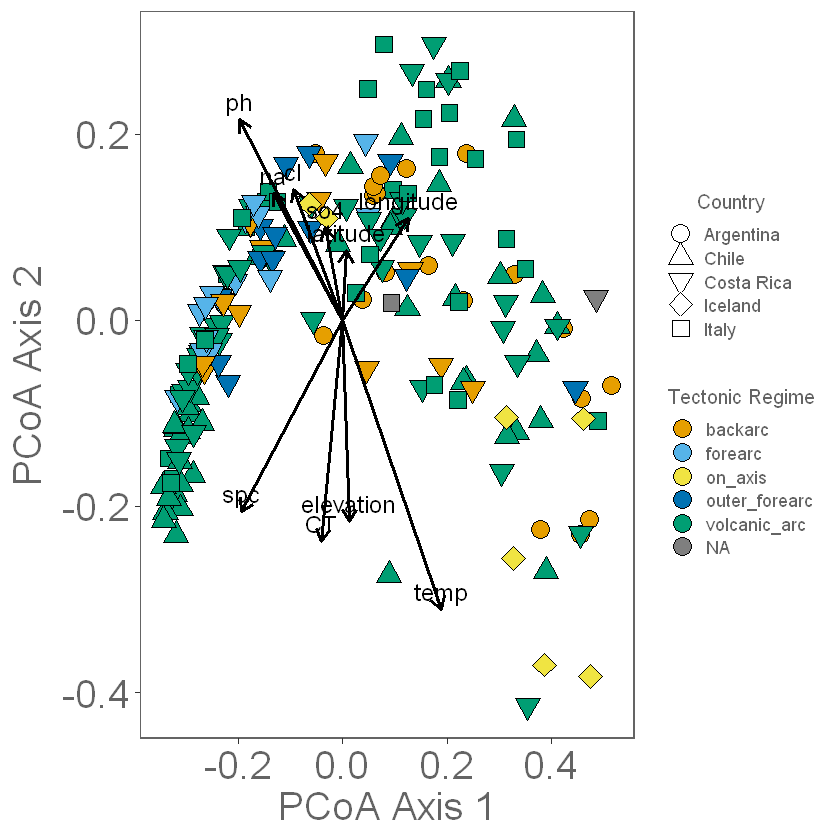

In [104]:
prok_pcoa_juw <- ordinate(bgc_n_data, prok_dist_unjac, method = "PCoA")

coords <- as.data.frame(prok_pcoa_juw$vectors)
coords$SampleID <- rownames(coords)

meta <- as.data.frame(sample_data(bgc_n_data))
meta$SampleID <- rownames(meta)

# Merge metadata
coords <- left_join(coords, meta[, c("SampleID", "country", "tectonicType4",
                                     "temp", "ph", "CT", "cl", "so4", "spc", "elevation", "latitude", "longitude", "na")],
                    by = "SampleID")

# Run envfit
envfit_res <- envfit(prok_pcoa_juw$vectors, coords[, c("temp", "ph", "CT", "cl", "so4", "spc",
                                                       "elevation", "latitude", "longitude", "na")], permutations = 999)
arrows_df <- as.data.frame(scores(envfit_res, display = "vectors"))
arrows_df$Variable <- rownames(arrows_df)

# Color & shape settings
tectonic_colors <- c(
  "backarc" = "#E69F00",
  "forearc" = "#56B4E9",
  "volcanic_arc" = "#009E73",
  "on_axis" = "#F0E442",
  "outer_forearc" = "#0072B2",
  "NA" = "#999999"
)

country_shapes <- c(
  "Argentina" = 21,
  "Chile" = 24,
  "Italy" = 22,
  "Iceland" = 23,
  "Costa Rica" = 25
)

# Build plot (without clusters)
pcoa_plot <- ggplot(coords, aes(x = Axis.1, y = Axis.2)) +
  # Points with tectonic fill and country shape
  geom_point(aes(shape = country, fill = tectonicType4),
             size = 5, color = "black", stroke = 0.4) +
  scale_shape_manual(name = "Country", values = country_shapes) +
  scale_fill_manual(name = "Tectonic Regime", values = tectonic_colors) +

  # Environmental arrows
  geom_segment(data = arrows_df,
               aes(x = 0, y = 0, xend = Axis.1, yend = Axis.2),
               arrow = arrow(length = unit(0.3, "cm")),
               color = "black", size = 1) +
  geom_text(data = arrows_df,
            aes(x = Axis.1, y = Axis.2, label = Variable),
            color = "black", vjust = -0.5, size = 5) +

  # Labels
  labs(
    x = "PCoA Axis 1",
    y = "PCoA Axis 2"
  ) +

  # Legend layout
  guides(
    shape = guide_legend(order = 1, title.position = "top"),
    fill = guide_legend(order = 2, title.position = "top",
                        override.aes = list(shape = 21, color = "black", size = 5))
  ) +

  theme_glab(base_size = 14) +
  theme(
    legend.position = "right",
    legend.box = "vertical",
    legend.box.just = "left",
    legend.title.align = 0.5,
    legend.text = element_text(size = 11),
    legend.title = element_text(size = 12)
  )

# Save as Inkscape-friendly SVG
svglite("../figures/pcoa_combined_envfit_NO_K_MEAN.svg", width = 12, height = 6)
print(pcoa_plot)
dev.off()
print(pcoa_plot)


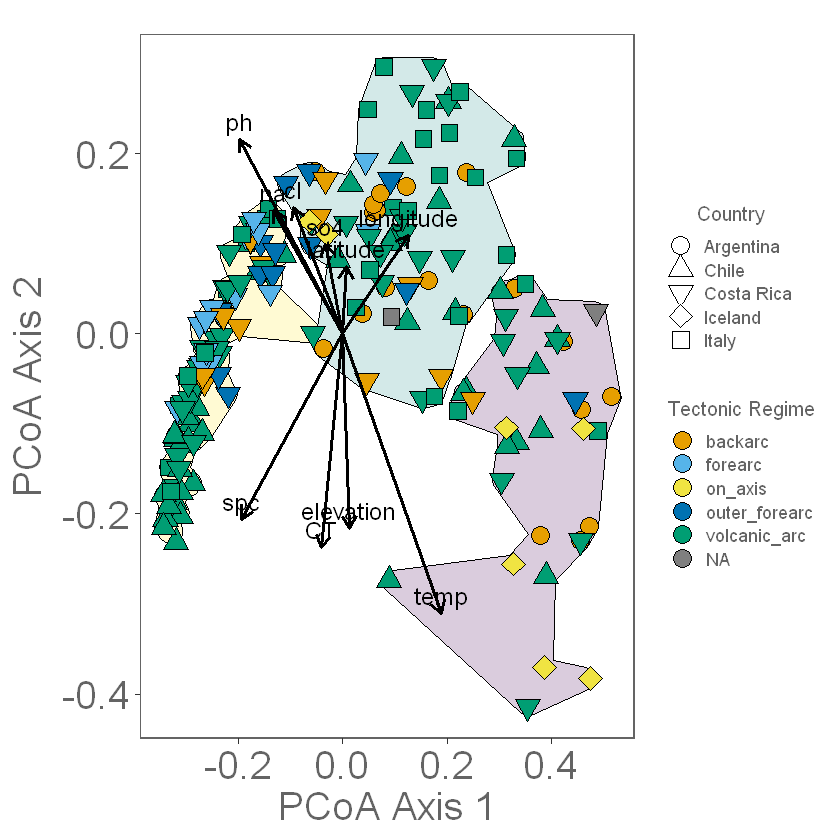

In [105]:
# Build PCoA
prok_pcoa_juw <- ordinate(bgc_n_data, prok_dist_unjac, method = "PCoA")

# Get Coordinates
coords <- as.data.frame(prok_pcoa_juw$vectors)
coords$SampleID <- rownames(coords)

# K-means clustering
set.seed(123)
k_res <- kmeans(coords[, c("Axis.1", "Axis.2")], centers = 3)
coords$Cluster <- as.factor(k_res$cluster)

# Metadata
meta <- as.data.frame(sample_data(bgc_n_data))
meta$SampleID <- rownames(meta)

# Merge metadata
coords <- left_join(coords, meta[, c("SampleID", "country", "tectonicType4",
                                     "temp", "ph", "CT", "cl", "so4", "spc", "elevation", "latitude", "longitude", "na")],
                    by = "SampleID")

# Run envfit
envfit_res <- envfit(prok_pcoa_juw$vectors, coords[, c("temp", "ph", "CT", "cl", "so4", "spc",
                                                       "elevation", "latitude", "longitude", "na")], permutations = 999)
arrows_df <- as.data.frame(scores(envfit_res, display = "vectors"))
arrows_df$Variable <- rownames(arrows_df)

# Custom colors & shapes
tectonic_colors <- c(
  "backarc" = "#E69F00",
  "forearc" = "#56B4E9",
  "volcanic_arc" = "#009E73",
  "on_axis" = "#F0E442",
  "outer_forearc" = "#0072B2",
  "NA" = "#999999"
)

country_shapes <- c(
  "Argentina" = 21,
  "Chile" = 24,
  "Italy" = 22,
  "Iceland" = 23,
  "Costa Rica" = 25
)

# Build the plot
ggplot(coords, aes(x = Axis.1, y = Axis.2)) +
  # Convex hulls instead of ellipses
  ggforce::geom_mark_hull(aes(group = Cluster, fill = Cluster),
                          alpha = 0.2, concavity = 2, expand = unit(2, "mm"),
                          show.legend = FALSE) +
  scale_fill_viridis_d(name = "Cluster", option = "D") +

  # New fill scale for tectonic regime
  ggnewscale::new_scale_fill() +

  # Points with tectonic fill and country shape
  geom_point(aes(shape = country, fill = tectonicType4),
             size = 5, color = "black", stroke = 0.4) +
  scale_shape_manual(name = "Country", values = country_shapes) +
  scale_fill_manual(name = "Tectonic Regime", values = tectonic_colors) +

  # Environmental arrows
  geom_segment(data = arrows_df,
               aes(x = 0, y = 0, xend = Axis.1, yend = Axis.2),
               arrow = arrow(length = unit(0.3, "cm")),
               color = "black", size = 1) +
  geom_text(data = arrows_df,
            aes(x = Axis.1, y = Axis.2, label = Variable),
            color = "black", vjust = -0.5, size = 5) +

  # Labels
  labs(
    title = "",
    x = "PCoA Axis 1",
    y = "PCoA Axis 2"
  ) +

  # Legend layout with color fix
  guides(
    shape = guide_legend(order = 1, title.position = "top"),
    fill = guide_legend(order = 2, title.position = "top",
                        override.aes = list(shape = 21, color = "black", size = 5))
  ) +

  theme_glab(base_size = 14) +
  theme(
    legend.position = "right",
    legend.box = "vertical",
    legend.box.just = "left",
    legend.title.align = 0.5,
    legend.text = element_text(size = 11),
    legend.title = element_text(size = 12)
  )


ggsave(
  filename = "../figures/pcoa_unweighted_combined_envfit_hulls.svg",
  device = "svg",
  width = 12,
  height = 6
)


# Save a CSV with SampleID and Cluster   
write.csv(coords[, c("SampleID", "Cluster")],
          "sample_clusters.csv",
          row.names = FALSE)


In [106]:
# Create distance matrix again (if not already)
clr_dist_matrix <- phyloseq::distance(bgc_n_data, method = "jaccard")

# Run PERMANOVA on the cluster labels
perm_cluster <- adonis2(clr_dist_matrix ~ Cluster, data = coords)

# View the results
print(perm_cluster)


Permutation test for adonis under reduced model
Permutation: free
Number of permutations: 999

adonis2(formula = clr_dist_matrix ~ Cluster, data = coords)
          Df SumOfSqs      R2      F Pr(>F)    
Model      2    7.791 0.16229 19.082  0.001 ***
Residual 197   40.219 0.83771                  
Total    199   48.010 1.00000                  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [107]:
# Extract vectors
envfit_table <- as.data.frame(scores(envfit_res, display = "vectors"))

# Inspect column names to see what they are
print(colnames(envfit_table))

# Add r² and p-values
envfit_table$r2 <- envfit_res$r
envfit_table$p_value <- envfit_res$vectors$pvals
envfit_table$Variable <- rownames(envfit_table)

# View the full table
print(envfit_table)


[1] "Axis.1" "Axis.2"
                Axis.1      Axis.2 p_value  Variable
temp       0.188793702 -0.31052994   0.001      temp
ph        -0.196920834  0.21543676   0.001        ph
CT        -0.039846464 -0.23748710   0.002        CT
cl        -0.093884737  0.14037163   0.056        cl
so4       -0.033198025  0.09943998   0.346       so4
spc       -0.194181536 -0.20587028   0.001       spc
elevation  0.012858187 -0.21619198   0.004 elevation
latitude   0.007460724  0.07457908   0.556  latitude
longitude  0.125723849  0.10920698   0.058 longitude
na        -0.132967141  0.13670162   0.034        na


# Cluster Percentages & Permanova Tests

Rows: 13 Columns: 3
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): tectonic_type4
dbl (2): cluster, percentage_contribution

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


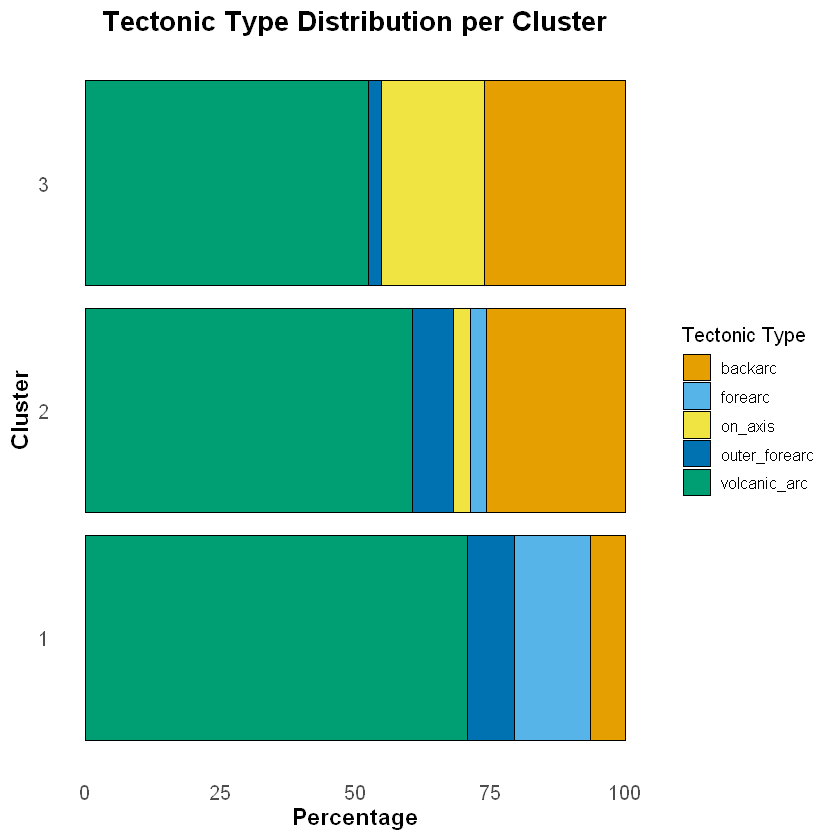

In [108]:
# Read the CSV file
df <- read_csv("cluster_tectonictype4_percentage.csv")
# Ensure Cluster is a factor
df$cluster <- as.factor(df$cluster)

# Define custom colors for tectonic types
tectonic_colors <- c(
  "backarc" = "#E69F00",
  "forearc" = "#56B4E9",
  "volcanic_arc" = "#009E73",
  "on_axis" = "#F0E442",
  "outer_forearc" = "#0072B2"
)

# Plot
ggplot(df, aes(x = percentage_contribution, y = cluster, fill = tectonic_type4)) +
  geom_bar(stat = "identity", position = "stack", color = "black") +
  scale_fill_manual(values = tectonic_colors) +
  labs(
    title = "Tectonic Type Distribution per Cluster",
    x = "Percentage",
    y = "Cluster",
    fill = "Tectonic Type"
  ) +
  theme_minimal() +
  theme(
    axis.text = element_text(size = 12),
    axis.title = element_text(size = 14, face = "bold"),
    legend.position = "right",
    plot.title = element_text(size = 16, hjust = 0.5, face = "bold"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
  )

# Save the plot 

ggsave(
  filename = "../figures/Tectonic_Type_Distribution.svg",
  device = "svg",
  width = 12,
  height = 6
)



In [109]:
#permanova by pH

# Extract sample data from phyloseq object and convert to data frame
group_df <- data.frame(sample_data(bgc_n_data))

# Ensure that the factors are correctly set
group_df$ph <- factor(group_df$ph)

clr_dist_matrix <- phyloseq::distance(bgc_n_data, method = "jaccard")

# Perform PERMANOVA using adonis2
perm_results <- adonis2(clr_dist_matrix ~ ph, data = group_df)

# Print PERMANOVA results
print(perm_results)

Permutation test for adonis under reduced model
Permutation: free
Number of permutations: 999

adonis2(formula = clr_dist_matrix ~ ph, data = group_df)
          Df SumOfSqs      R2      F Pr(>F)    
Model    111   32.053 0.66763 1.5925  0.001 ***
Residual  88   15.957 0.33237                  
Total    199   48.010 1.00000                  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [110]:
#permanova by temperature

# Extract sample data from phyloseq object and convert to data frame
group_df <- data.frame(sample_data(bgc_n_data))

# Ensure that the factors are correctly set
group_df$temp <- factor(group_df$temp)

clr_dist_matrix <- phyloseq::distance(bgc_n_data, method = "jaccard")

# Perform PERMANOVA using adonis2
perm_results <- adonis2(clr_dist_matrix ~ temp, data = group_df)

# Print PERMANOVA results
print(perm_results)

Permutation test for adonis under reduced model
Permutation: free
Number of permutations: 999

adonis2(formula = clr_dist_matrix ~ temp, data = group_df)
          Df SumOfSqs      R2     F Pr(>F)    
Model    122   33.832 0.70468 1.506  0.001 ***
Residual  77   14.178 0.29532                 
Total    199   48.010 1.00000                 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [111]:
#permanova by CT (Crustal thickness)

# Extract sample data from phyloseq object and convert to data frame
group_df <- data.frame(sample_data(bgc_n_data))

# Ensure that the factors are correctly set
group_df$CT <- factor(group_df$CT)

clr_dist_matrix <- phyloseq::distance(bgc_n_data, method = "jaccard")

# Perform PERMANOVA using adonis2
perm_results <- adonis2(clr_dist_matrix ~ CT, data = group_df)

# Print PERMANOVA results
print(perm_results)

Permutation test for adonis under reduced model
Permutation: free
Number of permutations: 999

adonis2(formula = clr_dist_matrix ~ CT, data = group_df)
          Df SumOfSqs     R2      F Pr(>F)   
Model    139   36.454 0.7593 1.3617  0.003 **
Residual  60   11.556 0.2407                 
Total    199   48.010 1.0000                 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [112]:
#permanova by spc (Conductivity)

# Extract sample data from phyloseq object and convert to data frame
group_df <- data.frame(sample_data(bgc_n_data))

# Ensure that the factors are correctly set
group_df$spc <- factor(group_df$spc)

clr_dist_matrix <- phyloseq::distance(bgc_n_data, method = "jaccard")

# Perform PERMANOVA using adonis2
perm_results <- adonis2(clr_dist_matrix ~ spc, data = group_df)

# Print PERMANOVA results
print(perm_results)

Permutation test for adonis under reduced model
Permutation: free
Number of permutations: 999

adonis2(formula = clr_dist_matrix ~ spc, data = group_df)
          Df SumOfSqs      R2      F Pr(>F)    
Model    126   33.807 0.70417 1.3791  0.001 ***
Residual  73   14.203 0.29583                  
Total    199   48.010 1.00000                  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


# How to know how many clusters are optimal in the PCoA?

In [113]:
# Run PCoA
prok_pcoa_juw <- ordinate(bgc_n_data, prok_dist_unjac, method = "PCoA")

# Get coordinates
coords <- as.data.frame(prok_pcoa_juw$vectors)
coords$SampleID <- rownames(coords)

# Just use Axis.1 and Axis.2 for clustering
data_for_clustering <- coords[, c("Axis.1", "Axis.2")]


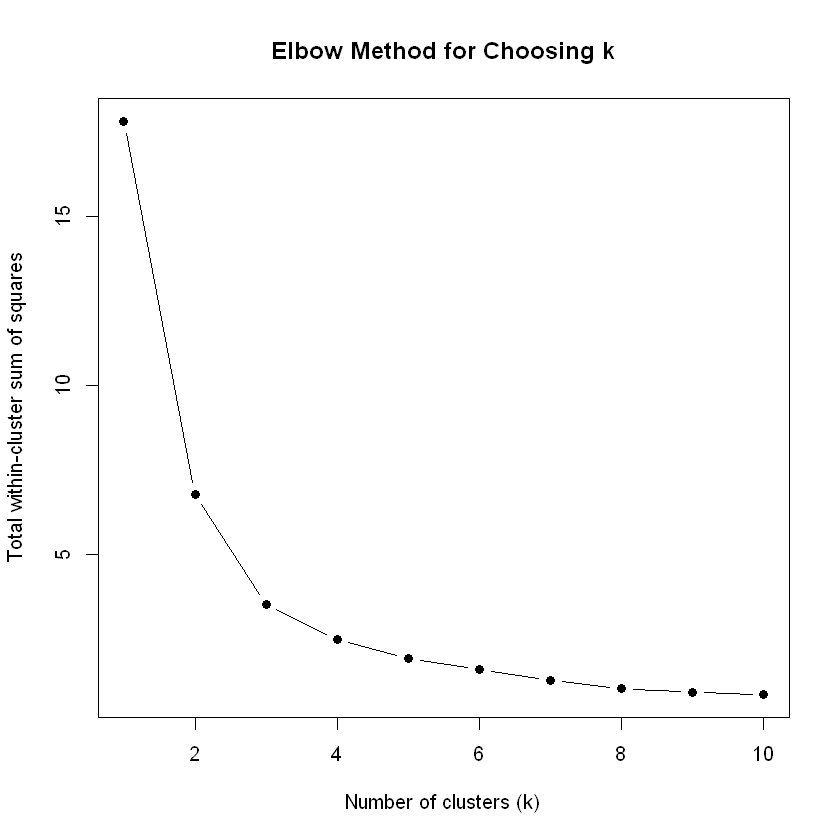

In [114]:
wss <- sapply(1:10, function(k) {
  kmeans(data_for_clustering, centers = k, nstart = 10)$tot.withinss
})

plot(1:10, wss, type = "b", pch = 19,
     xlab = "Number of clusters (k)",
     ylab = "Total within-cluster sum of squares",
     main = "Elbow Method for Choosing k")


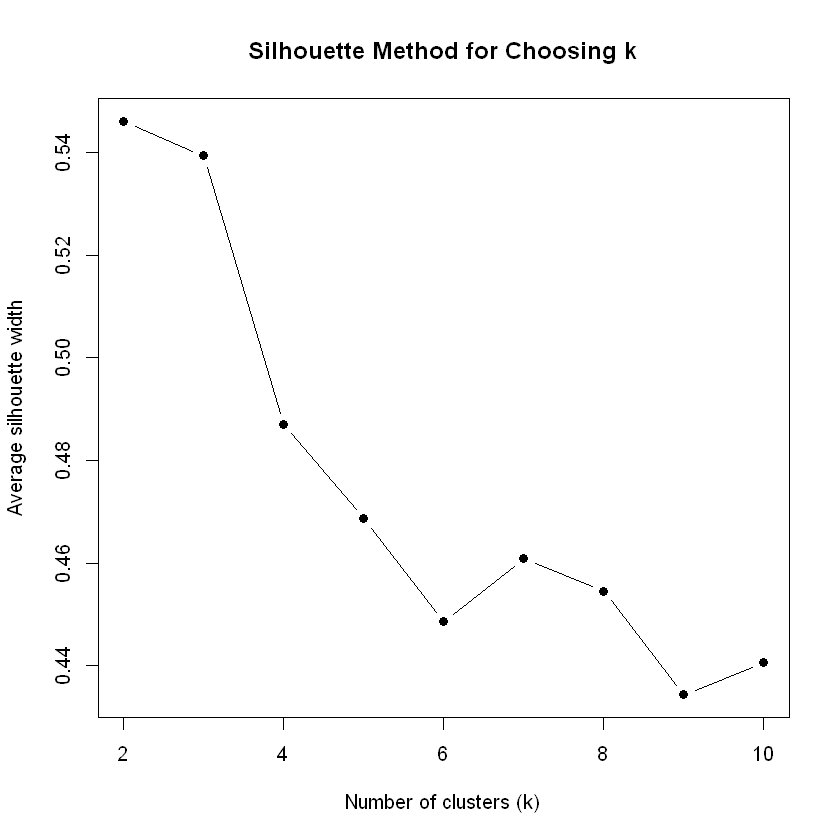

In [115]:
library(cluster)

sil_widths <- sapply(2:10, function(k) {
  km <- kmeans(data_for_clustering, centers = k, nstart = 10)
  ss <- silhouette(km$cluster, dist(data_for_clustering))
  mean(ss[, 3])
})

plot(2:10, sil_widths, type = "b", pch = 19,
     xlab = "Number of clusters (k)",
     ylab = "Average silhouette width",
     main = "Silhouette Method for Choosing k")


# Relative abundance of BGCs within clusters

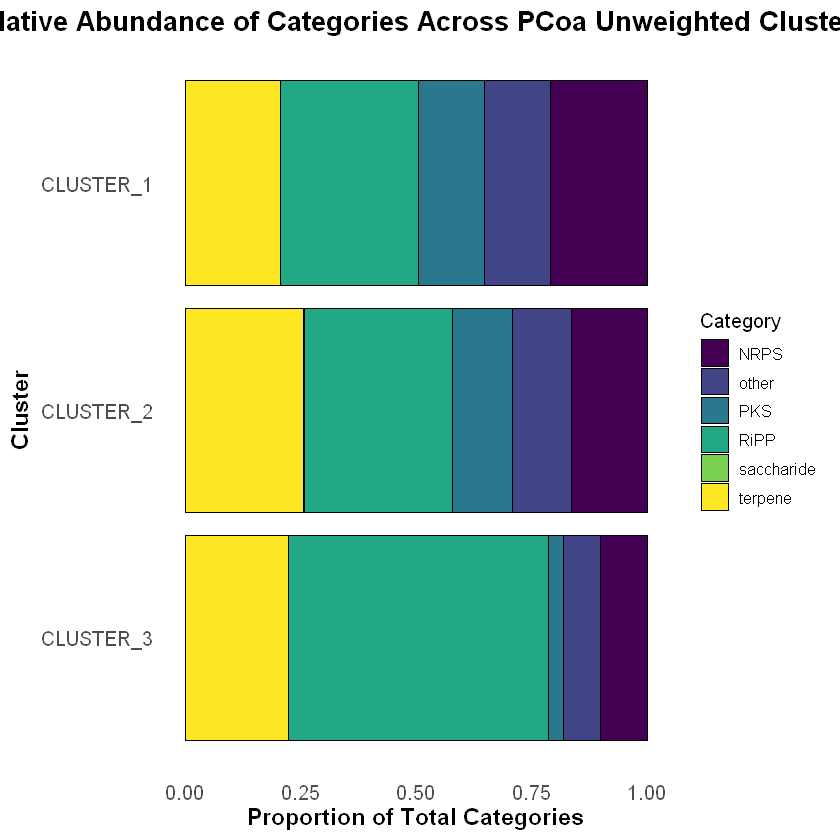

In [116]:
#Directory has csv's organized by clusters
base_folder <- "Clusters_Used_Unweighted"

# List all cluster folders (CLUSTER_1, CLUSTER_2, CLUSTER_3, etc.)
cluster_folders <- list.dirs(path = base_folder, recursive = FALSE)

# Initialize an empty data frame to store combined data
combined_data <- data.frame()

# Loop through each cluster folder
for (cluster in cluster_folders) {
  cluster_name <- basename(cluster)

  # List all CSV files in subfolders
  csv_files <- list.files(path = cluster, pattern = "\\.csv$", full.names = TRUE, recursive = TRUE)

  # Read and preprocess the data
  cluster_data <- lapply(csv_files, function(file) {
    df <- read.csv(file, stringsAsFactors = FALSE)
    if (nrow(df) == 0) {
      return(NULL)
    }
    df$Cluster <- cluster_name  # Add cluster label
    return(df)
  })

  # Combine data from all CSVs in this cluster
  cluster_data <- do.call(rbind, cluster_data)

  # Append to the combined data
  combined_data <- rbind(combined_data, cluster_data)
}

# Summarize data to get the count of categories per cluster
summary_data <- combined_data %>%
  group_by(Cluster, Category) %>%
  summarise(Count = n(), .groups = "drop") %>%
  group_by(Cluster) %>%
  mutate(Proportion = Count / sum(Count))

# Reorder Cluster factor so CLUSTER_1 is on top
summary_data$Cluster <- factor(summary_data$Cluster, levels = sort(unique(summary_data$Cluster), decreasing = TRUE))

# Plot the relative abundance
rel_abundance_plot <- ggplot(summary_data, aes(x = Proportion, y = Cluster, fill = Category)) +
  geom_bar(stat = "identity", position = "stack", color = "black") +
  scale_fill_viridis_d(option = "viridis") +
  labs(title = "Relative Abundance of Categories Across PCoa Unweighted Clusters",
       x = "Proportion of Total Categories",
       y = "Cluster") +
  theme_minimal() +
  theme(
    axis.text = element_text(size = 12),
    axis.title = element_text(size = 14, face = "bold"),
    legend.position = "right",
    plot.title = element_text(size = 16, hjust = 0.5, face = "bold"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
  )

# Print the plot
print(rel_abundance_plot)

# Save plot as SVG
ggsave(
  filename = "../figures/relative_abundance_cluster_PCOA_unweighted.svg",
  plot = rel_abundance_plot,
  device = "svg",
  width = 12,
  height = 6
)

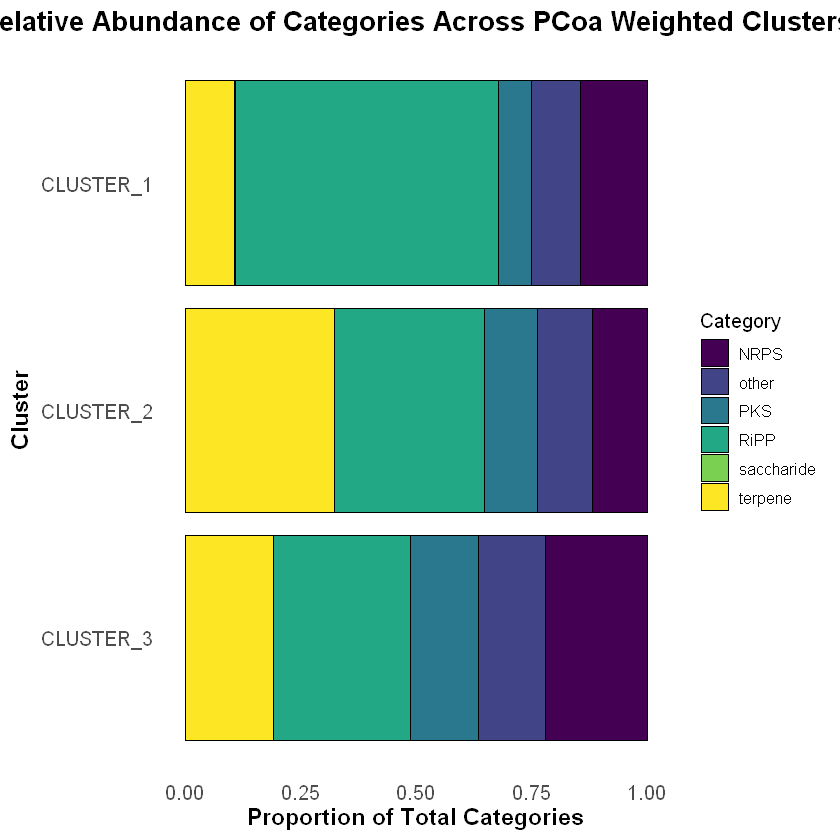

In [117]:
#Directory has csv's organized by clusters
base_folder <- "Clusters_Used_Weighted"

# List all cluster folders
cluster_folders <- list.dirs(path = base_folder, recursive = FALSE)

# Initialize an empty data frame
combined_data <- data.frame()

# Loop through cluster folders
for (cluster in cluster_folders) {
  cluster_name <- basename(cluster)

  # Find CSVs
  csv_files <- list.files(path = cluster, pattern = "\\.csv$", full.names = TRUE, recursive = TRUE)

  # Read and tag data
  cluster_data <- lapply(csv_files, function(file) {
    df <- read.csv(file, stringsAsFactors = FALSE)
    if (nrow(df) == 0) return(NULL)
    df$Cluster <- cluster_name
    return(df)
  })

  # Combine
  cluster_data <- do.call(rbind, cluster_data)
  combined_data <- rbind(combined_data, cluster_data)
}

# Summarize and calculate proportions
summary_data <- combined_data %>%
  group_by(Cluster, Category) %>%
  summarise(Count = n(), .groups = "drop") %>%
  group_by(Cluster) %>%
  mutate(Proportion = Count / sum(Count))

# Reorder Cluster so CLUSTER_1 is on top
summary_data$Cluster <- factor(summary_data$Cluster, levels = sort(unique(summary_data$Cluster), decreasing = TRUE))

# Create the plot and store it
rel_abundance_plot <- ggplot(summary_data, aes(x = Proportion, y = Cluster, fill = Category)) +
  geom_bar(stat = "identity", position = "stack", color = "black") +
  scale_fill_viridis_d(option = "viridis") +
  labs(title = "Relative Abundance of Categories Across PCoa Weighted Clusters",
       x = "Proportion of Total Categories",
       y = "Cluster") +
  theme_minimal() +
  theme(
    axis.text = element_text(size = 12),
    axis.title = element_text(size = 14, face = "bold"),
    legend.position = "right",
    plot.title = element_text(size = 16, hjust = 0.5, face = "bold"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
  )


print(rel_abundance_plot)

ggsave(
  filename = "../figures/relative_abundance_cluster_PCOA_weighted.svg",
  device = "svg",
  width = 12,
  height = 6
)


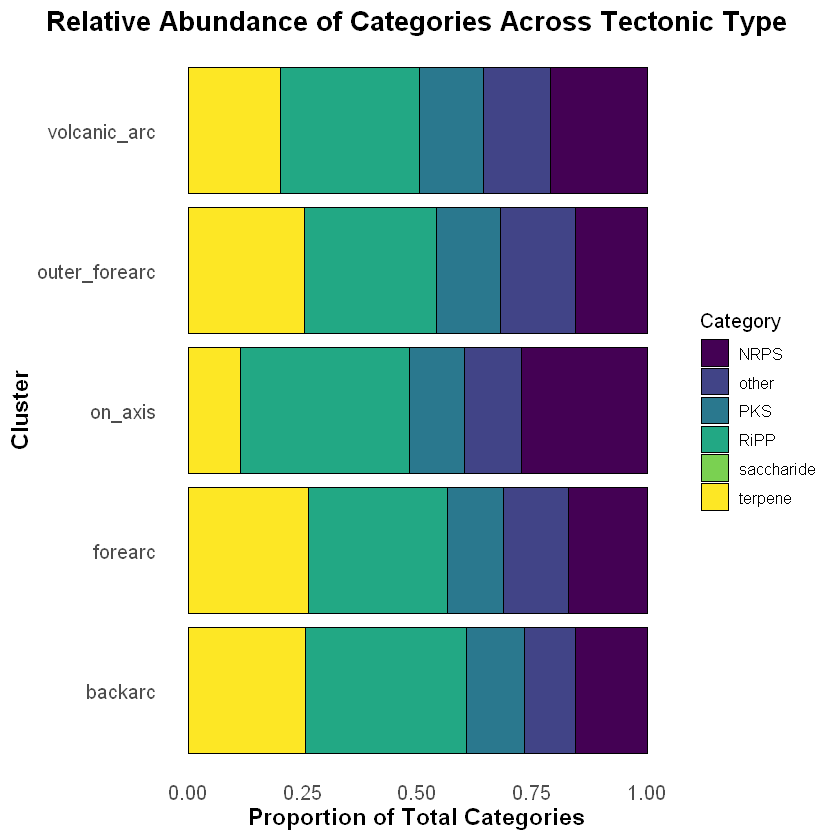

In [118]:
#Directory has csv's organized by tectonics
base_folder <- "Clusters_Used_Tectonics"

# List all cluster folders (CLUSTER_1, CLUSTER_2, CLUSTER_3)
cluster_folders <- list.dirs(path = base_folder, recursive = FALSE)

# Initialize an empty data frame to store combined data
combined_data <- data.frame()

# Loop through each cluster folder
for (cluster in cluster_folders) {
  cluster_name <- basename(cluster)

  # List all CSV files in subfolders
  csv_files <- list.files(path = cluster, pattern = "\\.csv$", full.names = TRUE, recursive = TRUE)

  # Read and preprocess the data
  cluster_data <- lapply(csv_files, function(file) {
    df <- read.csv(file, stringsAsFactors = FALSE)
    if (nrow(df) == 0) {
      return(NULL)
    }
    # Add Cluster column
    df$Cluster <- cluster_name
    return(df)
  })

  # Combine data from all CSVs in this cluster
  cluster_data <- do.call(rbind, cluster_data)

  # Append to the combined data
  combined_data <- rbind(combined_data, cluster_data)
}

# Summarize data to get the count of categories per cluster
summary_data <- combined_data %>%
  group_by(Cluster, Category) %>%
  summarise(Count = n(), .groups = "drop") %>%
  group_by(Cluster) %>%
  mutate(Proportion = Count / sum(Count))  # Calculate relative abundance

# Plot the relative abundance
ggplot(summary_data, aes(x = Proportion, y = Cluster, fill = Category)) +
  geom_bar(stat = "identity", position = "stack", color = "black") +
  scale_fill_viridis_d(option = "viridis") + 
  labs(title = "Relative Abundance of Categories Across Tectonic Type",
       x = "Proportion of Total Categories",
       y = "Cluster") +
  theme_minimal() +
  theme(
    axis.text = element_text(size = 12),
    axis.title = element_text(size = 14, face = "bold"),
    legend.position = "right",
    plot.title = element_text(size = 16, hjust = 0.5, face = "bold"),
    panel.grid.major = element_blank(),  # Remove major grid lines
    panel.grid.minor = element_blank()   # Remove minor grid lines
  )

ggsave(
  filename = "../figures/relative_abundance_by_tectonics.svg",
  device = "svg",
  width = 12,
  height = 6
)


In [119]:
#Directory has csv's organized by tectonics
 base_folder <- "Clusters_Used_Tectonics"

# List all tectonic folders (e.g., volcanic_arc, backarc, etc.)
cluster_folders <- list.dirs(path = base_folder, recursive = FALSE)

# Initialize combined data frame
combined_data <- data.frame()

# Loop through folders and collect data
for (cluster in cluster_folders) {
  cluster_name <- basename(cluster)
  csv_files <- list.files(path = cluster, pattern = "\\.csv$", full.names = TRUE, recursive = TRUE)

  for (file in csv_files) {
    df <- read.csv(file, stringsAsFactors = FALSE)
    if (nrow(df) == 0) next
    df$Cluster <- cluster_name
    combined_data <- rbind(combined_data, df)
  }
}

# Compute category percentages per tectonic setting
percentage_table <- combined_data %>%
  group_by(Cluster, Category) %>%
  summarise(Count = n(), .groups = "drop") %>%
  group_by(Cluster) %>%
  mutate(
    Total = sum(Count),
    Percentage = round((Count / Total) * 100, 2)
  ) %>%
  select(Cluster, Category, Count, Percentage)

# View result
print(percentage_table)

# Export to CSV
write.csv(percentage_table, "BGC_Percentages_by_TectonicSetting.csv", row.names = FALSE)


# A tibble: 26 × 4
# Groups:   Cluster [5]
   Cluster Category Count Percentage
   <chr>   <chr>    <int>      <dbl>
 1 backarc NRPS       157       15.6
 2 backarc PKS        126       12.6
 3 backarc RiPP       353       35.2
 4 backarc other      112       11.2
 5 backarc terpene    256       25.5
 6 forearc NRPS       230       17.3
 7 forearc PKS        162       12.2
 8 forearc RiPP       402       30.2
 9 forearc other      189       14.2
10 forearc terpene    349       26.2
# ℹ 16 more rows


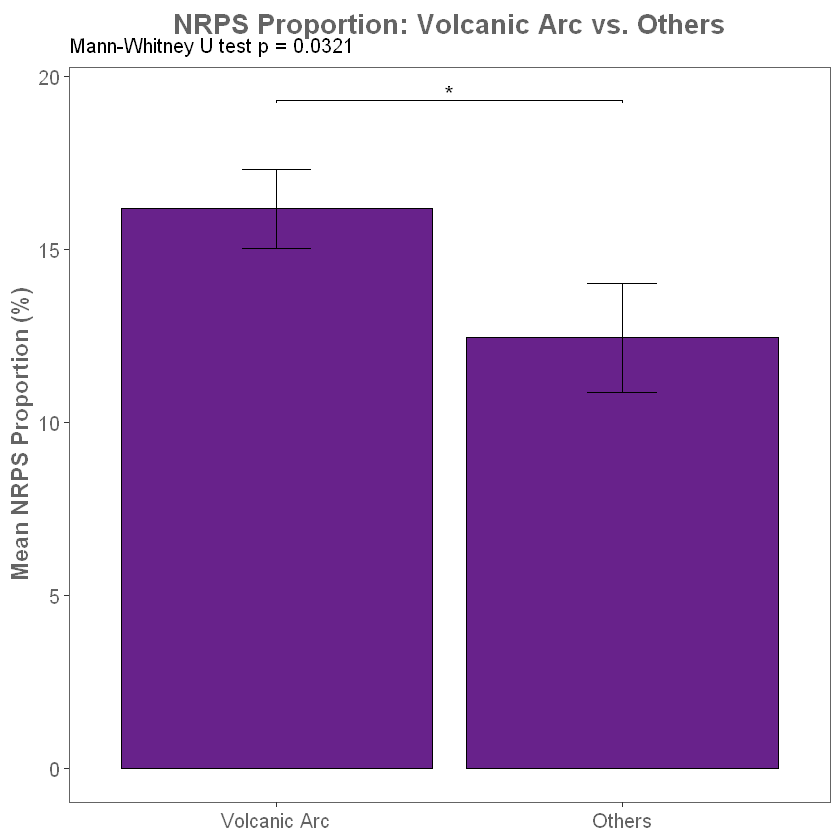

In [120]:
#Directory has csv's organized by tectonics
base_folder <- "Clusters_Used_Tectonics"

cluster_folders <- list.dirs(path = base_folder, recursive = FALSE)

combined_data <- data.frame()

for (cluster in cluster_folders) {
  cluster_name <- basename(cluster)
  csv_files <- list.files(path = cluster, pattern = "\\.csv$", full.names = TRUE, recursive = TRUE)
  
  for (file in csv_files) {
    df <- read.csv(file, stringsAsFactors = FALSE)
    if (nrow(df) == 0) next
    df$Cluster <- cluster_name
    df$Sample <- basename(file)
    combined_data <- rbind(combined_data, df)
  }
}

# Relative Abundance
replicate_data <- combined_data %>%
  group_by(Cluster, Sample, Category) %>%
  summarise(Count = n(), .groups = "drop") %>%
  group_by(Cluster, Sample) %>%
  mutate(Proportion = Count / sum(Count)) %>%
  ungroup()

# All Samples
all_samples <- replicate_data %>%
  select(Cluster, Sample) %>%
  distinct()

# NRPS Percentage per Sample 
nrps_percentages <- replicate_data %>%
  filter(Category == "NRPS") %>%
  mutate(Percentage = Proportion * 100) %>%
  select(Cluster, Sample, Percentage)

nrps_complete <- all_samples %>%
  left_join(nrps_percentages, by = c("Cluster", "Sample")) %>%
  mutate(
    Percentage = ifelse(is.na(Percentage), 0, Percentage),
    Group = ifelse(Cluster == "volcanic_arc", "Volcanic Arc", "Others")
  )

# Ensure factor order
nrps_complete$Group <- factor(nrps_complete$Group, levels = c("Volcanic Arc", "Others"))

# Mann-Whitney U test
mw_test <- wilcox.test(Percentage ~ Group, data = nrps_complete, exact = FALSE)
p_val <- mw_test$p.value

# Significance Label
sig_label <- case_when(
  p_val < 0.001 ~ "***",
  p_val < 0.01  ~ "**",
  p_val < 0.05  ~ "*",
  TRUE          ~ "ns"
)

#  Summarize for Plot
nrps_summary <- nrps_complete %>%
  group_by(Group) %>%
  summarise(
    Mean = mean(Percentage),
    SE = sd(Percentage) / sqrt(n()),
    .groups = "drop"
  )


ggplot(nrps_summary, aes(x = Group, y = Mean)) +
  geom_bar(stat = "identity", fill = "darkorchid4", color = "black") +
  geom_errorbar(aes(ymin = Mean - SE, ymax = Mean + SE), width = 0.2) +
  geom_signif(
    annotations = sig_label,
    y_position = max(nrps_summary$Mean + nrps_summary$SE) + 2,
    xmin = 1, xmax = 2,
    tip_length = 0.01,
    textsize = 5,
    vjust = 0.5
  ) +
  labs(
    title = "NRPS Proportion: Volcanic Arc vs. Others",
    subtitle = paste("Mann-Whitney U test p =", signif(p_val, 3)),
    x = NULL,
    y = "Mean NRPS Proportion (%)"
  ) +
  theme_glab() +  
  theme(
    axis.text = element_text(size = 12),
    axis.title = element_text(size = 14, face = "bold"),
    plot.title = element_text(size = 16, hjust = 0.5, face = "bold"),
    plot.subtitle = element_text(size = 12)
  )



ggsave(
  filename = "../figures/NRPS_volcanic_vs_others_MWU.svg",
  device = "svg",
  width = 12,
  height = 6
)


In [121]:
# Run Wilcoxon rank-sum test
wilcox_result <- wilcox.test(Percentage ~ Group, data = nrps_complete)
p_val <- wilcox_result$p.value

# Define significance label
sig_label <- case_when(
  p_val < 0.001 ~ "***",
  p_val < 0.01  ~ "**",
  p_val < 0.05  ~ "*",
  TRUE          ~ "ns"
)

# Summary stats for plotting
nrps_summary <- nrps_complete %>%
  group_by(Group) %>%
  summarise(
    Mean = mean(Percentage),
    SE = sd(Percentage) / sqrt(n()),
    .groups = "drop"
  )


In [122]:
# Full result
wilcox_result



	Wilcoxon rank sum test with continuity correction

data:  Percentage by Group
W = 4264.5, p-value = 0.03212
alternative hypothesis: true location shift is not equal to 0


In [123]:
cat("Wilcoxon rank-sum test\n",
    "W =", wilcox_result$statistic,
    "\np =", signif(wilcox_result$p.value, 3), "\n")


Wilcoxon rank-sum test
 W = 4264.5 
p = 0.0321 


Unique cluster names found:
[1] "backarc"                   "forearc"                  
[3] "on_axis"                   "outer_forearc"            
[5] "post-subduction Extension" "volcanic_arc"             


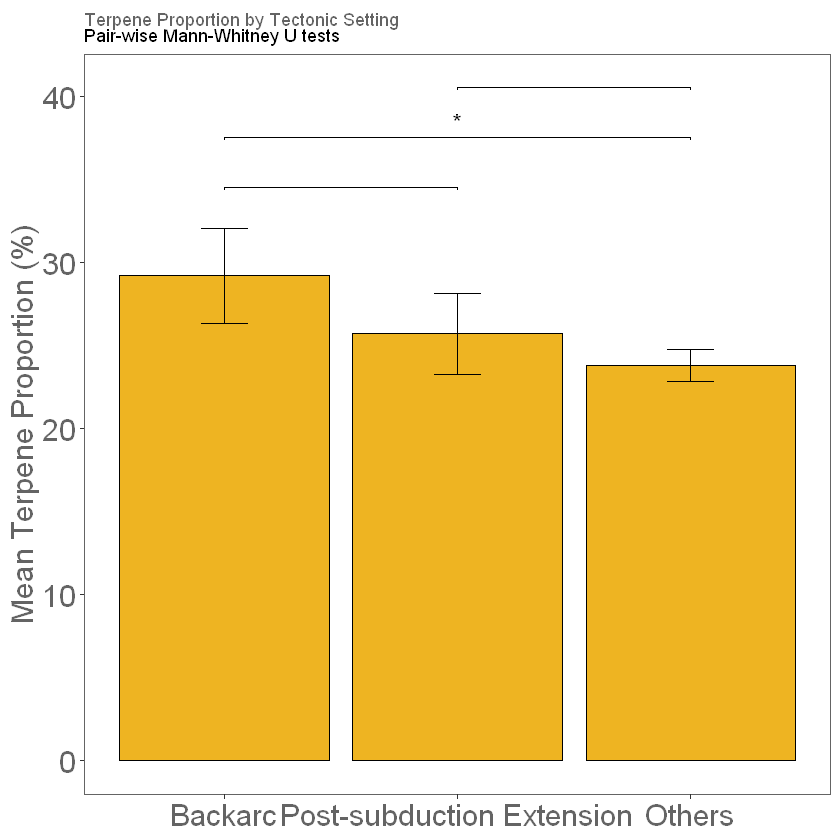

In [124]:
#Directory has csv's organized by tectonics
base_folder <- "Clusters_Used_Tectonics"

cluster_folders <- list.dirs(path = base_folder, recursive = FALSE)

combined_data <- data.frame()

for (cluster in cluster_folders) {
  cluster_name <- basename(cluster)
  csv_files <- list.files(cluster, pattern = "\\.csv$", full.names = TRUE, recursive = TRUE)
  for (f in csv_files) {
    df <- read.csv(f, stringsAsFactors = FALSE)
    if (nrow(df) == 0) next
    df$Cluster <- cluster_name
    df$Sample  <- basename(f)
    combined_data <- rbind(combined_data, df)
  }
}

# Quick diagnostic: what clusters did we find?
cat("Unique cluster names found:\n")
print(unique(combined_data$Cluster))

# Map clusters → three groups
#    - Backarc  :   name contains exactly "backarc"
#    - Post-subduction Extension: name contains "extensional" OR "post" & "subduction"
#    - Others   :   everything else

combined_data <- combined_data %>%
  mutate(Group = case_when(
    grepl("^backarc$", Cluster, ignore.case = TRUE)                       ~ "Backarc",
    grepl("extensional", Cluster, ignore.case = TRUE) |
      grepl("post[-_]?subduction", Cluster, ignore.case = TRUE)          ~ "Post-subduction Extension",
    TRUE                                                                 ~ "Others"
  ))

# Relative abundance & terpene percentage

replicate_data <- combined_data %>%
  group_by(Cluster, Sample, Category) %>%
  summarise(Count = n(), .groups = "drop") %>%
  group_by(Cluster, Sample) %>%
  mutate(Proportion = Count / sum(Count)) %>%
  ungroup()

terpene_perc <- replicate_data %>%
  filter(Category == "terpene") %>%
  mutate(Percentage = Proportion * 100) %>%
  left_join(distinct(combined_data, Sample, Group), by = "Sample")

# Pair-wise Mann-Whitney U tests (skip if a group is absent)

pairwise_tests <- list(
  c("Backarc", "Post-subduction Extension"),
  c("Backarc", "Others"),
  c("Post-subduction Extension", "Others")
)

comparisons_ok <- list()
sig_labels_ok  <- character()

for (cmp in pairwise_tests) {
  d <- terpene_perc %>% filter(Group %in% cmp)
  if (length(unique(d$Group)) == 2) {                       # both groups present
    p <- wilcox.test(Percentage ~ Group, data = d, exact = FALSE)$p.value
    sig <- case_when(
      p < 0.001 ~ "***",
      p < 0.01  ~ "**",
      p < 0.05  ~ "*",
      p < 0.1   ~ "†",
      TRUE      ~ ""
    )
    comparisons_ok <- append(comparisons_ok, list(cmp))
    sig_labels_ok  <- c(sig_labels_ok, sig)
  }
}

# Summary for bar plot

terpene_summary <- terpene_perc %>%
  group_by(Group) %>%
  summarise(
    Mean = mean(Percentage),
    SE   = sd(Percentage) / sqrt(n()),
    .groups = "drop"
  )

terpene_summary$Group <- factor(
  terpene_summary$Group,
  levels = c("Backarc", "Post-subduction Extension", "Others")
)


# Make plot

y_max <- max(terpene_summary$Mean + terpene_summary$SE, na.rm = TRUE)
y_pos <- y_max + seq(2, by = 3, length.out = length(comparisons_ok))

p <- ggplot(terpene_summary, aes(x = Group, y = Mean)) +
  geom_bar(stat = "identity", fill = "goldenrod2", color = "black") +
  geom_errorbar(aes(ymin = Mean - SE, ymax = Mean + SE), width = 0.2) +
  geom_signif(
    comparisons = comparisons_ok,
    annotations = sig_labels_ok,
    y_position  = y_pos,
    tip_length  = 0.01,
    textsize    = 5
  ) +
  labs(
    title = "Terpene Proportion by Tectonic Setting",
    subtitle = "Pair-wise Mann-Whitney U tests",
    x = NULL,
    y = "Mean Terpene Proportion (%)"
  ) +
  theme_glab(base_size = 11)

print(p)

# Save SVG

ggsave(
  filename = "../figures/Terpene_MWU_backarc_postSubd_others.svg",
  device = "svg",
  width = 12,
  height = 6
)



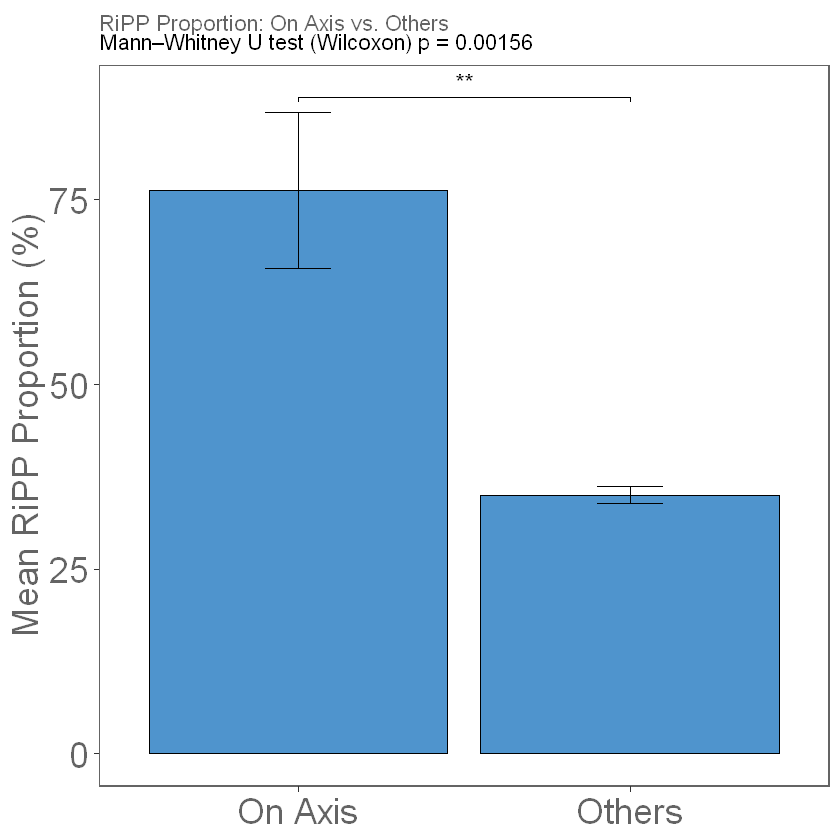

In [125]:
#Directory has csv's organized by tectonics
base_folder <- "Clusters_Used_Tectonics"

cluster_folders <- list.dirs(path = base_folder, recursive = FALSE)

combined_data <- data.frame()

for (cluster in cluster_folders) {
  cluster_name <- basename(cluster)
  csv_files <- list.files(path = cluster, pattern = "\\.csv$", full.names = TRUE, recursive = TRUE)

  for (file in csv_files) {
    df <- read.csv(file, stringsAsFactors = FALSE)
    if (nrow(df) == 0) next
    df$Cluster <- cluster_name
    df$Sample <- basename(file)
    combined_data <- rbind(combined_data, df)
  }
}

# Add Group: On Axis vs Others 
combined_data <- combined_data %>%
  mutate(Group = ifelse(Cluster == "on_axis", "On Axis", "Others"))

# Calculate RiPP Proportion per Sample 
replicate_data <- combined_data %>%
  group_by(Cluster, Sample, Category) %>%
  summarise(Count = n(), .groups = "drop") %>%
  group_by(Cluster, Sample) %>%
  mutate(Proportion = Count / sum(Count)) %>%
  ungroup()

sample_groups <- combined_data %>%
  select(Sample, Group) %>%
  distinct()

ripp_perc <- replicate_data %>%
  filter(Category == "RiPP") %>%
  mutate(Percentage = Proportion * 100) %>%
  left_join(sample_groups, by = "Sample")

# Run Mann–Whitney U test (Wilcoxon Rank-Sum)
test_result <- wilcox.test(Percentage ~ Group, data = ripp_perc)
p_val <- test_result$p.value

# Significance Label
sig_label <- case_when(
  p_val < 0.001 ~ "***",
  p_val < 0.01  ~ "**",
  p_val < 0.05  ~ "*",
  TRUE          ~ "ns"
)

# Summary for Plot 
ripp_summary <- ripp_perc %>%
  group_by(Group) %>%
  summarise(
    Mean = mean(Percentage),
    SE = sd(Percentage) / sqrt(n()),
    .groups = "drop"
  )

# Ensure factor order
ripp_summary$Group <- factor(ripp_summary$Group, levels = c("On Axis", "Others"))

# Plot 
ggplot(ripp_summary, aes(x = Group, y = Mean)) +
  geom_bar(stat = "identity", fill = "steelblue3", color = "black") +
  geom_errorbar(aes(ymin = Mean - SE, ymax = Mean + SE), width = 0.2) +
  geom_signif(
    annotations = sig_label,
    y_position = max(ripp_summary$Mean + ripp_summary$SE) + 2,
    xmin = 1, xmax = 2,
    tip_length = 0.01,
    textsize = 5
  ) +
  labs(
    title = "RiPP Proportion: On Axis vs. Others",
    subtitle = paste("Mann–Whitney U test (Wilcoxon) p =", signif(p_val, 3)),
    x = NULL,
    y = "Mean RiPP Proportion (%)"
  ) +
  theme_glab(base_size = 13)


ggsave(
  filename = "../figures/RiPP_MannWhitney_onaxis_vs_others.svg",
  device = "svg",
  width = 12,
  height = 6
)


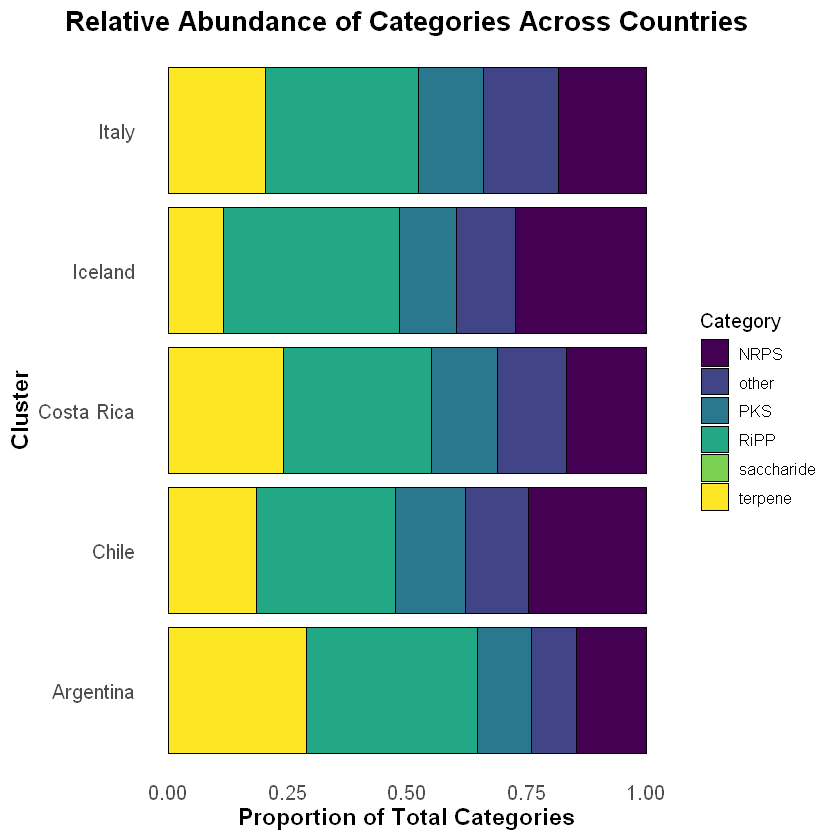

In [126]:
#Directory has csv's organized by expedition countries
base_folder <- "Clusters_Used_Countries_Expeditions"

# List all cluster folders (CLUSTER_1, CLUSTER_2, CLUSTER_3)
cluster_folders <- list.dirs(path = base_folder, recursive = FALSE)

# Initialize an empty data frame to store combined data
combined_data <- data.frame()

# Loop through each cluster folder
for (cluster in cluster_folders) {
  cluster_name <- basename(cluster)

  # List all CSV files in subfolders
  csv_files <- list.files(path = cluster, pattern = "\\.csv$", full.names = TRUE, recursive = TRUE)

  # Read and preprocess the data
  cluster_data <- lapply(csv_files, function(file) {
    df <- read.csv(file, stringsAsFactors = FALSE)
    if (nrow(df) == 0) {
      return(NULL)
    }
    # Add Cluster column
    df$Cluster <- cluster_name
    return(df)
  })

  # Combine data from all CSVs in this cluster
  cluster_data <- do.call(rbind, cluster_data)

  # Append to the combined data
  combined_data <- rbind(combined_data, cluster_data)
}

# Summarize data to get the count of categories per cluster
summary_data <- combined_data %>%
  group_by(Cluster, Category) %>%
  summarise(Count = n(), .groups = "drop") %>%
  group_by(Cluster) %>%
  mutate(Proportion = Count / sum(Count))  # Calculate relative abundance

# Plot the relative abundance
ggplot(summary_data, aes(x = Proportion, y = Cluster, fill = Category)) +
  geom_bar(stat = "identity", position = "stack", color = "black") +
  scale_fill_viridis_d(option = "viridis") +  # Use a vibrant color palette
  labs(title = "Relative Abundance of Categories Across Countries",
       x = "Proportion of Total Categories",
       y = "Cluster") +
  theme_minimal() +
  theme(
    axis.text = element_text(size = 12),
    axis.title = element_text(size = 14, face = "bold"),
    legend.position = "right",
    plot.title = element_text(size = 16, hjust = 0.5, face = "bold"),
    panel.grid.major = element_blank(),  # Remove major grid lines
    panel.grid.minor = element_blank()   # Remove minor grid lines
  )

ggsave(
  filename = "../figures/relative_abundance_by_country.svg",
  device = "svg",
  width = 12,
  height = 6
)

In [127]:
#Directory has csv's organized by expedition countries
base_folder <- "Clusters_UsedCountries_Expeditions"

cluster_folders <- list.dirs(path = base_folder, recursive = FALSE)

# Read and combine all data
combined_data <- data.frame()

for (cluster in cluster_folders) {
  cluster_name <- basename(cluster)
  csv_files <- list.files(path = cluster, pattern = "\\.csv$", full.names = TRUE, recursive = TRUE)
  
  for (file in csv_files) {
    df <- read.csv(file, stringsAsFactors = FALSE)
    if (nrow(df) == 0) next
    df$Cluster <- cluster_name
    combined_data <- rbind(combined_data, df)
  }
}

# Calculate category percentages per country (Cluster)
percentage_table <- combined_data %>%
  group_by(Cluster, Category) %>%
  summarise(Count = n(), .groups = "drop") %>%
  group_by(Cluster) %>%
  mutate(
    Total = sum(Count),
    Percentage = round((Count / Total) * 100, 2)
  ) %>%
  select(Cluster, Category, Count, Percentage)

# View table
print(percentage_table)

# export as CSV
write.csv(percentage_table, "Category_Percentages_by_Country.csv", row.names = FALSE)


# A tibble: 28 × 4
# Groups:   Cluster [5]
   Cluster   Category   Count Percentage
   <chr>     <chr>      <int>      <dbl>
 1 Argentina NRPS          77      14.7 
 2 Argentina PKS           60      11.4 
 3 Argentina RiPP         188      35.8 
 4 Argentina other         49       9.33
 5 Argentina terpene      151      28.8 
 6 Chile     NRPS        3423      24.7 
 7 Chile     PKS         2041      14.7 
 8 Chile     RiPP        4019      29.0 
 9 Chile     other       1839      13.3 
10 Chile     saccharide     1       0.01
# ℹ 18 more rows


# Environmental variables bar plot

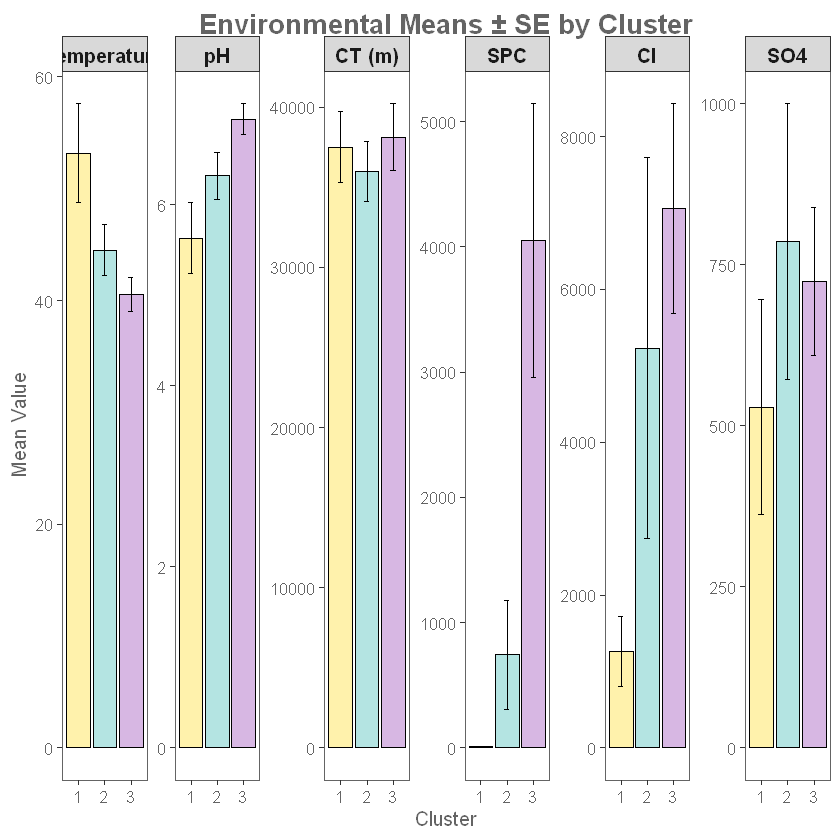

In [128]:
# Set file paths
env_path <- "env_data_BGC.xlsx"
cluster_path <- "sample_clusters.csv"

# Read environmental data
env_data <- read_excel(env_path, sheet = "envdata_template")

# Read and clean malformed cluster file 
clusters_raw <- readLines(cluster_path)
cleaned_rows <- strsplit(gsub('"', '', clusters_raw), split = ",")
clusters <- as.data.frame(do.call(rbind, cleaned_rows), stringsAsFactors = FALSE)
colnames(clusters) <- clusters[1, ]
clusters <- clusters[-1, ]
names(clusters)[names(clusters) == "SampleID"] <- "BIOSAMPLE_ID"
clusters$Cluster <- as.factor(clusters$Cluster)

# Merge and clean selected variables 
merged_data <- env_data %>%
  inner_join(clusters, by = "BIOSAMPLE_ID") %>%
  select(Cluster, temp, ph, CT, spc, cl, so4) %>%
  mutate(across(c(temp, ph, CT, spc, cl, so4), as.numeric))

#  Pivot longer & set variable order 
long_data <- merged_data %>%
  pivot_longer(cols = c(temp, ph, CT, spc, cl, so4),
               names_to = "Variable", values_to = "Value") %>%
  filter(!is.na(Value)) %>%
  mutate(
    Variable = factor(Variable, levels = c("temp", "ph", "CT", "spc", "cl", "so4","elevation"))
  )

# Calculate mean ± SE 
summary_data <- long_data %>%
  group_by(Cluster, Variable) %>%
  summarise(
    Mean = mean(Value),
    SD = sd(Value),
    N = n(),
    SE = SD / sqrt(N),
    .groups = "drop"
  )

# Plot with colorblind-friendly colors
bar_plot <- ggplot(summary_data, aes(x = Cluster, y = Mean, fill = Cluster)) +
  geom_bar(stat = "identity", color = "black", position = "dodge") +
  geom_errorbar(aes(ymin = Mean - SE, ymax = Mean + SE),
                width = 0.2, position = position_dodge(0.9)) +
  facet_wrap(~ Variable, scales = "free_y", nrow = 1,
             labeller = labeller(Variable = c(
               temp = "Temperature",
               ph = "pH",
               CT = "CT (m)",
               spc = "SPC",
               cl = "Cl",
               so4 = "SO4"
             ))) +
  scale_fill_manual(values = c(
    "1" = "#FFF2AC",  # pale yellow
    "2" = "#B4E4E2",  # pale teal
    "3" = "#D7B7E3"   # pale purple
  )) +
  labs(title = "Environmental Means ± SE by Cluster",
       x = "Cluster", y = "Mean Value") +
  theme_glab() +
  theme(
    plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
    strip.text = element_text(size = 12, face = "bold"),
    axis.text = element_text(size = 10),
    axis.title = element_text(size = 12),
    legend.position = "none"
  )

# Save the plot 

ggsave(
  filename = "../figures/final_env_means_plot.svg",
  device = "svg",
  width = 12,
  height = 6
)
# Show
print(bar_plot)

In [129]:
# Read files
env_data <- read_excel("env_data_BGC.xlsx", sheet = "envdata_template")
clusters_raw <- readLines("sample_clusters.csv")

cleaned_rows <- strsplit(gsub('"', '', clusters_raw), split = ",")
clusters <- as.data.frame(do.call(rbind, cleaned_rows), stringsAsFactors = FALSE)
colnames(clusters) <- clusters[1, ]
clusters <- clusters[-1, ]
names(clusters)[names(clusters) == "SampleID"] <- "BIOSAMPLE_ID"
clusters$Cluster <- as.factor(clusters$Cluster)

# Merge and select variables
merged_data <- env_data %>%
  inner_join(clusters, by = "BIOSAMPLE_ID") %>%
  select(Cluster, temp, ph, CT, spc, cl, so4) %>%
  mutate(across(c(temp, ph, CT, spc, cl, so4), as.numeric))

# List of variables to test
vars <- c("temp", "ph", "CT", "spc", "cl", "so4")

# Loop through each variable
for (v in vars) {
  cat("\n---", toupper(v), "---\n")
  kruskal <- kruskal.test(as.formula(paste(v, "~ Cluster")), data = merged_data)
  print(kruskal)
  
  if (kruskal$p.value < 0.05) {
    cat("Significant → Running Dunn's test:\n")
    dunn <- dunnTest(as.formula(paste(v, "~ Cluster")), data = merged_data, method = "bh")
    print(dunn)
  } else {
    cat("Not significant → Skipping post-hoc test.\n")
  }
}



--- TEMP ---

	Kruskal-Wallis rank sum test

data:  temp by Cluster
Kruskal-Wallis chi-squared = 3.9365, df = 2, p-value = 0.1397

Not significant → Skipping post-hoc test.

--- PH ---

	Kruskal-Wallis rank sum test

data:  ph by Cluster
Kruskal-Wallis chi-squared = 7.0388, df = 2, p-value = 0.02962

Significant → Running Dunn's test:


Warning message:
"Some rows deleted from 'x' and 'g' because missing data."
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




  Comparison         Z    P.unadj      P.adj
1      1 - 2 -0.930669 0.35202480 0.35202480
2      1 - 3 -2.509325 0.01209621 0.03628862
3      2 - 3 -1.743564 0.08123516 0.12185274

--- CT ---

	Kruskal-Wallis rank sum test

data:  CT by Cluster
Kruskal-Wallis chi-squared = 2.0788, df = 2, p-value = 0.3537

Not significant → Skipping post-hoc test.

--- SPC ---

	Kruskal-Wallis rank sum test

data:  spc by Cluster
Kruskal-Wallis chi-squared = 8.9591, df = 2, p-value = 0.01134

Significant → Running Dunn's test:


Warning message:
"Some rows deleted from 'x' and 'g' because missing data."
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




  Comparison          Z     P.unadj      P.adj
1      1 - 2 -0.5687564 0.569521464 0.56952146
2      1 - 3 -2.6554170 0.007921043 0.02376313
3      2 - 3 -2.2551433 0.024124334 0.03618650

--- CL ---

	Kruskal-Wallis rank sum test

data:  cl by Cluster
Kruskal-Wallis chi-squared = 21.532, df = 2, p-value = 2.111e-05

Significant → Running Dunn's test:


Warning message:
"Some rows deleted from 'x' and 'g' because missing data."
Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




  Comparison         Z      P.unadj        P.adj
1      1 - 2 -2.168793 3.009844e-02 3.009844e-02
2      1 - 3 -4.547965 5.416705e-06 1.625012e-05
3      2 - 3 -2.628568 8.574524e-03 1.286179e-02

--- SO4 ---

	Kruskal-Wallis rank sum test

data:  so4 by Cluster
Kruskal-Wallis chi-squared = 0.56496, df = 2, p-value = 0.7539

Not significant → Skipping post-hoc test.


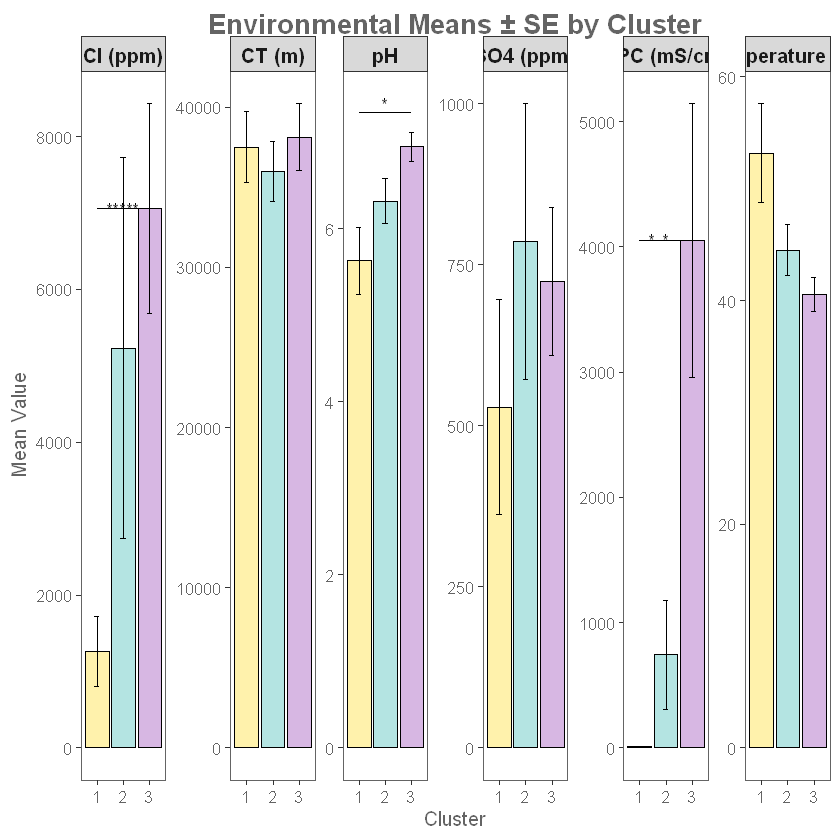

In [130]:
env_path <- "env_data_BGC.xlsx"
cluster_path <- "sample_clusters.csv"

# Read environmental data 
env_data <- read_excel(env_path, sheet = "envdata_template")

#  Read and clean malformed cluster file 
clusters_raw <- readLines(cluster_path)
cleaned_rows <- strsplit(gsub('"', '', clusters_raw), split = ",")
clusters <- as.data.frame(do.call(rbind, cleaned_rows), stringsAsFactors = FALSE)
colnames(clusters) <- clusters[1, ]
clusters <- clusters[-1, ]
names(clusters)[names(clusters) == "SampleID"] <- "BIOSAMPLE_ID"
clusters$Cluster <- as.factor(clusters$Cluster)

# Merge and clean selected variables
merged_data <- env_data %>%
  inner_join(clusters, by = "BIOSAMPLE_ID") %>%
  select(Cluster, temp, ph, CT, spc, cl, so4) %>%
  mutate(across(c(temp, ph, CT, spc, cl, so4), as.numeric))

# Pivot longer & set variable order 
long_data <- merged_data %>%
  pivot_longer(cols = c(temp, ph, CT, spc, cl, so4),
               names_to = "Variable", values_to = "Value") %>%
  filter(!is.na(Value)) %>%
  mutate(
    Variable = factor(Variable, levels = c("temp", "ph", "CT", "spc", "cl", "so4"))
  )

# Calculate mean ± SE 
summary_data <- long_data %>%
  group_by(Cluster, Variable) %>%
  summarise(
    Mean = mean(Value),
    SD = sd(Value),
    N = n(),
    SE = SD / sqrt(N),
    .groups = "drop"
  )

# Define stars manually based on your Dunn test results 
star_annotations <- data.frame(
  Variable = c("ph", "spc", "spc", "cl", "cl", "cl"),
  x1 = c(1, 1, 1, 1, 1, 2),
  x2 = c(3, 2, 3, 2, 3, 3),
  y = c(
    max(summary_data$Mean[summary_data$Variable == "ph"]) + 0.4,
    max(summary_data$Mean[summary_data$Variable == "spc"]) + 0.3,
    max(summary_data$Mean[summary_data$Variable == "spc"]) + 0.6,
    max(summary_data$Mean[summary_data$Variable == "cl"]) + 0.3,
    max(summary_data$Mean[summary_data$Variable == "cl"]) + 0.6,
    max(summary_data$Mean[summary_data$Variable == "cl"]) + 0.9
  ),
  label = c("*", "*", "*", "*", "***", "*")
)

# Plot with colorblind-friendly palette and stars
bar_plot <- ggplot(summary_data, aes(x = Cluster, y = Mean, fill = Cluster)) +
  geom_bar(stat = "identity", color = "black", position = "dodge") +
  geom_errorbar(aes(ymin = Mean - SE, ymax = Mean + SE),
                width = 0.2, position = position_dodge(0.9)) +

  # Add manual lines and stars for significance
  geom_segment(data = star_annotations, aes(x = x1, xend = x2, y = y, yend = y),
               inherit.aes = FALSE, linewidth = 0.4) +
  geom_text(data = star_annotations, aes(x = (x1 + x2)/2, y = y + 0.1, label = label),
            inherit.aes = FALSE, size = 4) +

  facet_wrap(~ Variable, scales = "free_y", nrow = 1,
             labeller = labeller(Variable = c(
               temp = "Temperature (°C)",
               ph = "pH",
               CT = "CT (m)",
               spc = "SPC (mS/cm)",
               cl = "Cl (ppm)",
               so4 = "SO4 (ppm)"
             ))) +
  scale_fill_manual(values = c(
    "1" = "#FFF2AC",  # pale yellow
    "2" = "#B4E4E2",  # pale teal
    "3" = "#D7B7E3"   # pale purple
  )) +
  labs(title = "Environmental Means ± SE by Cluster",
       x = "Cluster", y = "Mean Value") +
  theme_glab() +
  theme(
    plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
    strip.text = element_text(size = 12, face = "bold"),
    axis.text = element_text(size = 10),
    axis.title = element_text(size = 12),
    legend.position = "none"
  )


ggsave(
  filename = "../figures/final_env_means_plot_with_stars.svg",
  device = "svg",
  width = 12,
  height = 6
)

print(bar_plot)





# Absolute abundances box plots!

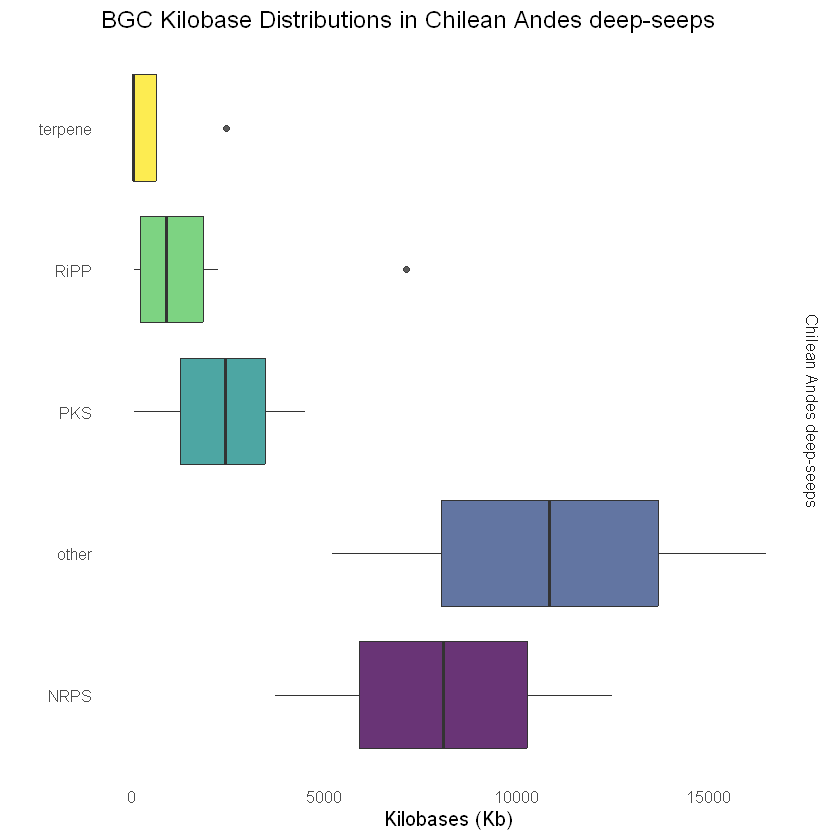

In [132]:
# Initialize lists to store results
dict_all_sites <- list()
num_seq_all_sites <- list()

# Read JSON file
data_list <- fromJSON("../resources/dict_all_sites_ch22.json", flatten = TRUE)
data_list <- fromJSON("../resources/dict_all_sites_fenix.json", flatten = TRUE)
data_list <- fromJSON("../resources/dict_all_sites_AEO22.json", flatten = TRUE)
data_list <- fromJSON("../resources/dict_all_sites_ARG19.json", flatten = TRUE)
data_list <- fromJSON("../resources/dict_all_sites_cluster1.json", flatten = TRUE)
data_list <- fromJSON("../resources/dict_all_sites_cluster2.json", flatten = TRUE)
data_list <- fromJSON("../resources/dict_all_sites_cluster3.json", flatten = TRUE)
data_list <- fromJSON("../resources/dict_all_sites_cr17.json", flatten = TRUE)
data_list <- fromJSON("../resources/dict_all_sites_ISL21.json", flatten = TRUE)

# Convert nested lists into a dataframe
df_all_sites <- bind_rows(data_list)

# Add site type column - Change as needed
df_all_sites$Site_Type <- "Chilean Andes deep-seeps"

# Read JSON file
num_seq_all_sites <- fromJSON("../resources/num_seq_all_sites_ch22.json", flatten = TRUE)
num_seq_all_sites <- fromJSON("../resources/num_seq_all_sites_fenix.json", flatten = TRUE)
num_seq_all_sites <- fromJSON("../resources/num_seq_all_sites_AEO22.json", flatten = TRUE)
num_seq_all_sites <- fromJSON("../resources/num_seq_all_sites_ARG19.json", flatten = TRUE)
num_seq_all_sites <- fromJSON("../resources/num_seq_all_sites_cluster1.json", flatten = TRUE)
num_seq_all_sites <- fromJSON("../resources/num_seq_all_sites_cluster2.json", flatten = TRUE)
num_seq_all_sites <- fromJSON("../resources/num_seq_all_sites_cluster3.json", flatten = TRUE)
num_seq_all_sites <- fromJSON("../resources/num_seq_all_sites_cr17.json", flatten = TRUE)
num_seq_all_sites <- fromJSON("../resources/num_seq_all_sites_ISL21.json", flatten = TRUE)

# Convert list of small data frames into a single data frame
df_violin <- num_seq_all_sites

# Process df_violin
df_violin <- df_violin %>%
  select(num_seq) %>%
  mutate(Site_Type = 'CHILE 22')

# Define the color palette using viridis
color_palette <- viridis_pal(option = "plasma")(1)

# Create box plot using viridis color scale
kilobase_box <- ggplot(df_all_sites, aes(x = num_seq, y = category, fill = category)) +
  geom_boxplot(alpha = 0.8) +
  scale_fill_viridis_d(option = "viridis") +  # Use viridis colors
  facet_grid(rows = vars(Site_Type)) +
  labs(title = "BGC Kilobase Distributions in Chilean Andes deep-seeps",
       x = "Kilobases (Kb)",
       y = "") +
  theme_minimal() +
  theme(legend.position = "none",
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        text = element_text(family = "Helvetica"))

print(kilobase_box)

# MAPS

File already exists ; loading 'marmap_coord_-80;-55;-40;-10_res_4.csv'

File already exists ; loading 'marmap_coord_-90;5;-75;15_res_4.csv'

File already exists ; loading 'marmap_coord_5;35;20;48_res_4.csv'

File already exists ; loading 'marmap_coord_-30;62;-10;67_res_4.csv'



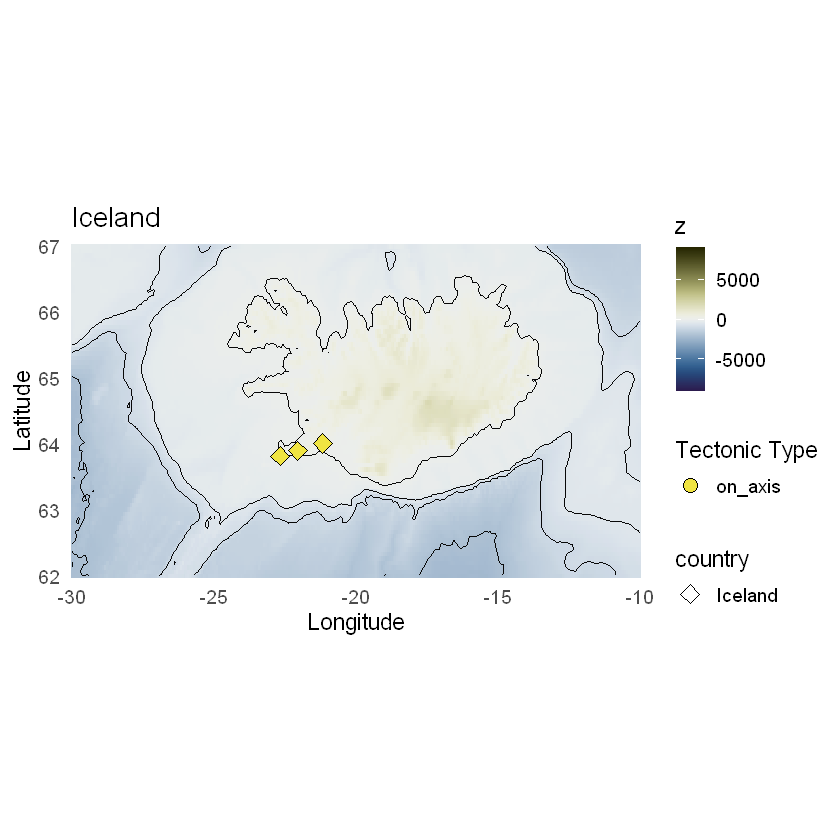

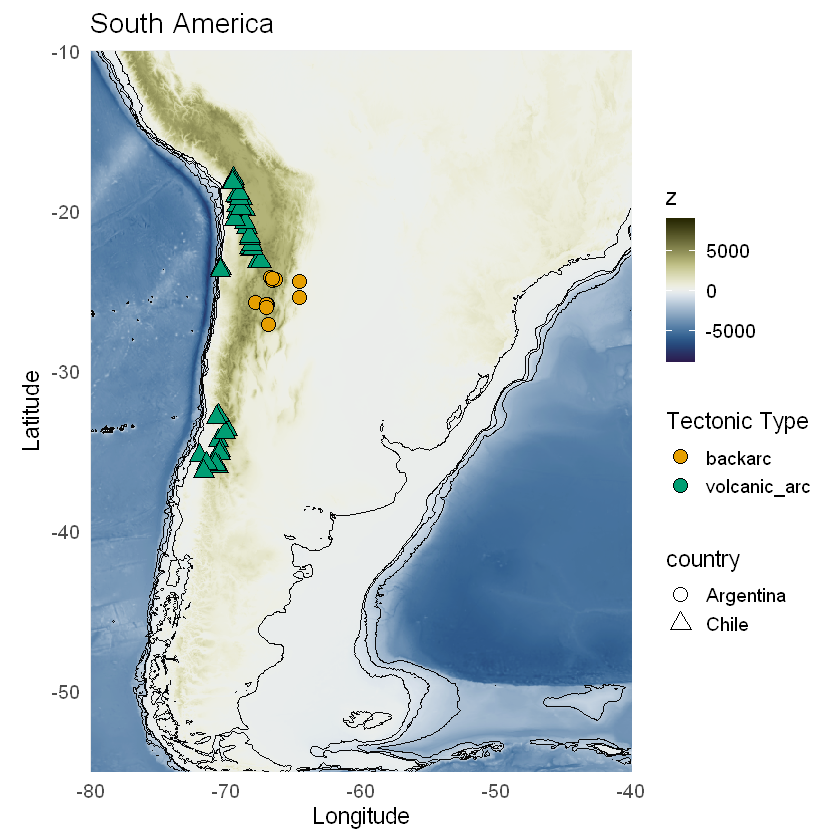

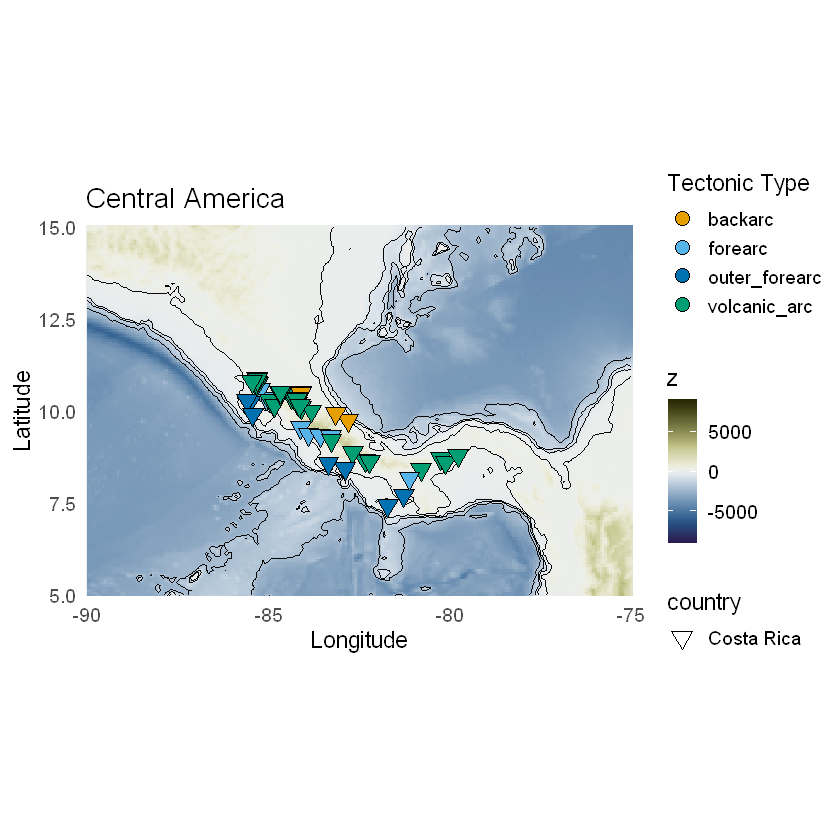

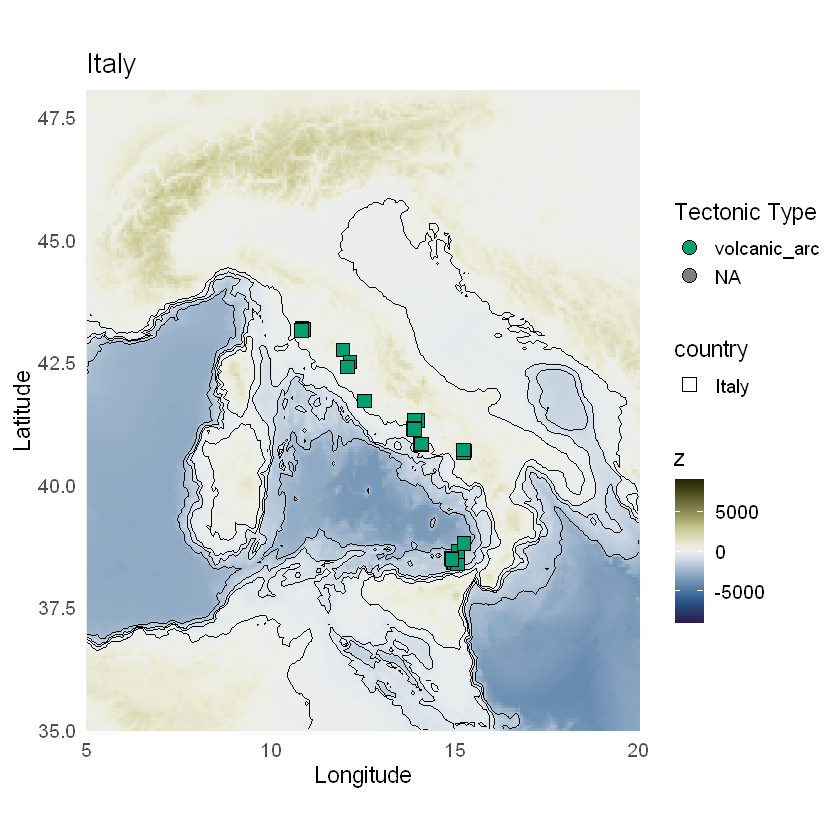

In [133]:
# Load your Excel data
env_data <- read_excel("env_data_BGC.xlsx", sheet = "envdata_template")
env_data <- env_data[!is.na(env_data$latitude) & !is.na(env_data$longitude), ]

# Define subsets by region
south_america <- env_data[env_data$latitude < -10 & env_data$longitude < -30, ]
central_america <- env_data[env_data$country == "Costa Rica", ]
italy <- env_data[env_data$country == "Italy", ]
iceland <- env_data[env_data$country == "Iceland", ]

# Color palette for tectonic types
tectonic_colors <- c(
  "backarc" = "#E69F00",       # red
  "forearc" = "#56B4E9",       # blue
  "volcanic_arc" = "#009E73",  # green
  "on_axis" = "#F0E442",       # purple
  "outer_forearc" = "#0072B2", # orange
  "NA" = "999999"
)

# Shape values for countries
country_shapes <- c(
  "Argentina" = 21,    # circle
  "Chile" = 24,        # triangle
  "Italy" = 22,        # square
  "Iceland" = 23,      # diamond
  "Costa Rica" = 25    # upside-down triangle
)

# Function to create each regional map
make_map <- function(data, lon1, lon2, lat1, lat2, region_name) {
  bat <- getNOAA.bathy(lon1, lon2, lat1, lat2, res = 4, keep = TRUE)

  ggplot(bat, aes(x = x, y = y)) +
    coord_quickmap() +
    geom_raster(aes(fill = z)) +
    scale_fill_scico(palette = "broc", limits = c(-9000, 9000)) +
    geom_contour(aes(z = z), breaks = c(0, -500, -1000, -2000, -10000),
                 colour = "grey3", size = 0.1) +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(expand = c(0, 0)) +
    new_scale_fill() +
    geom_point(data = data, aes(x = longitude, y = latitude,
                                fill = tectonicType4,
                                shape = country),
               size = 4, color = "black", stroke = 0.5) +
    scale_shape_manual(values = country_shapes) +
    scale_fill_manual(values = tectonic_colors, name = "Tectonic Type") +
    guides(
      fill = guide_legend(override.aes = list(shape = 21)),
      shape = guide_legend(override.aes = list(fill = "white"))
    ) +
    labs(title = region_name,
         x = "Longitude",
         y = "Latitude",
         z = "Elevation (m)") +
    theme_minimal(base_size = 14)
}

# Create maps
map_south_america <- make_map(south_america, -80, -40, -55, -10, "South America")
map_central_america <- make_map(central_america, -90, -75, 5, 15, "Central America")
map_italy <- make_map(italy, 5, 20, 35, 48, "Italy")
map_iceland <- make_map(iceland, -30, -10, 62, 67, "Iceland")

# Save all maps to Desktop (update path if your username is different)
ggsave(
  filename = "../figures/map_iceland_editable.svg",
  plot = map_iceland,
  device = "svg",
  width = 12,
  height = 6
)
print(map_iceland)
ggsave(
  filename = "../figures/map_south_america_editable.svg",
  plot = map_south_america,
  device = "svg",
  width = 12,
  height = 6
)
print(map_south_america)

ggsave(
  filename = "../figures/map_central_america_editable.svg",
  plot = map_central_america,
  device = "svg",
  width = 12,
  height = 6
)
print(map_central_america)

ggsave(
  filename = "../figures/map_italy_editable.svg",
  plot = map_italy,
  device = "svg",
  width = 12,
  height = 6
)
print(map_italy)